# Summarize Design Results For 1-Story Building

In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Define the number of stories that we are interested in
total_story = 1

# Define a boolean variable: consider constructability or not
is_construction = True

# Base directory: where the SeismicDesignModule package is stored
base_directory = 'C:\\Users\\Lenovo\\Documents\\GitHub\\AutoSDA'

# Postprocessing folder path
postprocessing_directory = base_directory + '\\Poseprocessing\\SeismicDesign'

# Preprocessing folder path
preprocessing_directory = base_directory + '\\Preprocessing\\SeismicDesign'

# Design results folder path
design_directory = base_directory + '\\BuildingData'

# Load the section database
os.chdir(base_directory)
with open('AllSectionDatabase.csv', 'r') as file:
    SECTION_DATABASE = pd.read_csv(file, header=0)

# Load the design sampling space
os.chdir(preprocessing_directory)
with open('DesignSheet2.csv', 'r') as file:
    DESIGN_SPACE = pd.read_csv(file, header=0)
    
def search_section_property(target_size, section_database):
    """
    This function is used to obtain the section property when section size is given.
    The output will be stored in a dictionary.
    :param target_size: a string which defines section size, e.g. 'W14X500'
    :param section_database: a dataframe read from SMF_Section_Property.csv in "Library" folder
    :return: section_info: a dictionary which includes section size, index, and associated properties.
    """
    # Loop over the sections in the SMF section database and find the one which matches the target size
    # Then the property of the target section is returned as a dictionary.
    # If target size cannot match any existing sizes in database, a warning message should be given.
    try:
        for indx in np.array(section_database['index']):
            if target_size == section_database.loc[indx, 'section size']:
                section_info = section_database.loc[indx, :]
        return section_info.to_dict()
    except:
        sys.stderr.write('Error: wrong size nominated!\nNo such size exists in section database!')
        sys.exit(1)

        
def extract_member_results(target_IDs, file_name):
    """
    :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalMemberSize.csv' or 'ConstructionSize.csv',
    :return members: a dictionary which includes three lists.
                     Each list has X element, where X is the number of total buildings that we are interested.
                     Each element is further a list with Y elements, where Y is the number of stories for each building.
    """
    # Initialize three lists to store member sizes for a bunch of buildings
    beam = []
    exterior_column = []
    interior_column = []
    for ID in target_IDs:
        # Open the folder and read the target files
        target_path = design_directory + "\\Building_" + str(ID)
        os.chdir(target_path)
        with open(file_name, 'r') as file:
            MemberSize = pd.read_csv(file, header=0)
        StoryNumber = MemberSize.shape[0]
        # Initialize three lists to store the member sizes for different stories in each building
        beam_per_building = []
        exterior_column_per_building = []
        interior_column_per_building = []
        # Loop all stories to read the sizes
        for story in range(0, StoryNumber):
            beam_per_building.append(MemberSize.loc[story, 'beam'])
            exterior_column_per_building.append(MemberSize.loc[story, 'exterior column'])
            interior_column_per_building.append(MemberSize.loc[story, 'interior column'])
        beam.append(beam_per_building)
        exterior_column.append(exterior_column_per_building)
        interior_column.append(interior_column_per_building)
    # Store all results into the dictionary
    members = {'beam': beam, 'exterior column': exterior_column, 'interior column': interior_column}
    return members
    

def extract_section_property(number_building, number_story ,members, SECTION_DATABASE, target_quantity):
    """
    This function is used to extract the properties for a bunch of building cases.
    :param number_building: a integer denoting total number of buildings for the current analysis
    :param members: a dictionary which includes three lists: beam, exterior/interior column sizes.
                    each list contains the section sizes for a bunch of buildings.
                    each element in the list is further a list, 
                    which includes the sizes for different stories in a certain building.
    :param SECTION_DATABASE: a dataframe including all steel sections
    :param target_quantity: a string to denote the target quantity name. e.g. 'Ix', 'Zx', 'Weight'
                            options for this string is the header name in SECTION_DATABASE.
    :return member_property: a dictionary which includes three lists.
                             Each list has X element, where X is the number of total buildings that we are interested.
                             Each element is further a list with Y elements, where Y is the number of stories for each building.
    """
    # Initialize three list to store the function output
    beam_property = []
    exterior_column_property = []
    interior_column_property = []
    # Loop over all buildings to extract the information
    for each in range(0, number_building):
        # Initialize the list to store the information for each building. The length is equal to building stories.
        beam_per_building = []
        exterior_column_per_building = []
        interior_column_per_building = []
        # Loop over all stories for a certain building and attach each member property into the list
        for story in range(0, number_story):
            beam_per_building.append(search_section_property(members['beam'][each][story], 
                                                             SECTION_DATABASE)[target_quantity])
            exterior_column_per_building.append(search_section_property(members['exterior column'][each][story], 
                                                                        SECTION_DATABASE)[target_quantity]) 
            interior_column_per_building.append(search_section_property(members['interior column'][each][story], 
                                                                        SECTION_DATABASE)[target_quantity])
        beam_property.append(beam_per_building)
        exterior_column_property.append(exterior_column_per_building)
        interior_column_property.append(interior_column_per_building)
    # Store all results into the dictionary
    member_property = {'beam': beam_property, 
                       'exterior column': exterior_column_property, 
                       'interior column': interior_column_property}
    return member_property

def extract_story_drift(target_IDs, file_name, is_final_drift):
    """
    This function is used to extract the story drifts from building design results.
    :param: target_IDs: :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalDrift.csv', 'ConstructionDrift.csv'
    :param is_final_drift: a boolean variable to denote whether the user wants to compute the final drift or not.
                           If true, the drift read from results should multiply with 5.5 and 1.1 to account for 
                                    the plastic modification factor and RBS stiffness reduction.
                           If false, the drift is simply the value read from design result.
    :return: a list with X elements, where X is the number of buildings that we are interested.
             each element is further a list with Y elements. Y is the number of stories for each building.
    """
    # Initialize a list to store the function output
    story_drift = []
    for ID in target_IDs:
        drift_per_building = []
        target_path = design_directory + "\\Building_" + str(ID)
        os.chdir(target_path)
        with open(file_name, 'r') as file1:
            StoryDrift = pd.read_csv(file1, header=0)
        RowNumber = StoryDrift.shape[0]
        for story in range(RowNumber):
            if(is_final_drift):
                drift_per_building.append(StoryDrift.loc[story, 'story drift']*5.5*1.1*100)
            else:
                drift_per_building.append(StoryDrift.loc[story, 'story drift']*100)
        story_drift.append(drift_per_building)
    return story_drift

In [2]:
# Find the building IDs that we are interested in.
target_IDs = []
row_number = DESIGN_SPACE.shape[0]
for indx in range(0, row_number):
    if DESIGN_SPACE.loc[indx, 'number of story'] == total_story:
        target_IDs.append(DESIGN_SPACE.loc[indx, 'building ID'])    

In [3]:
# Options for file_name: 'OptimalMemberSize.csv' or 'ConstructionSize.csv'
if (is_construction):
    file_name = 'ConstructionSize.csv'
else:
    file_name = 'OptimalMemberSize.csv'
members = extract_member_results(target_IDs, file_name)

# Plot Ix vs. Story Level

In [4]:
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'Ix')

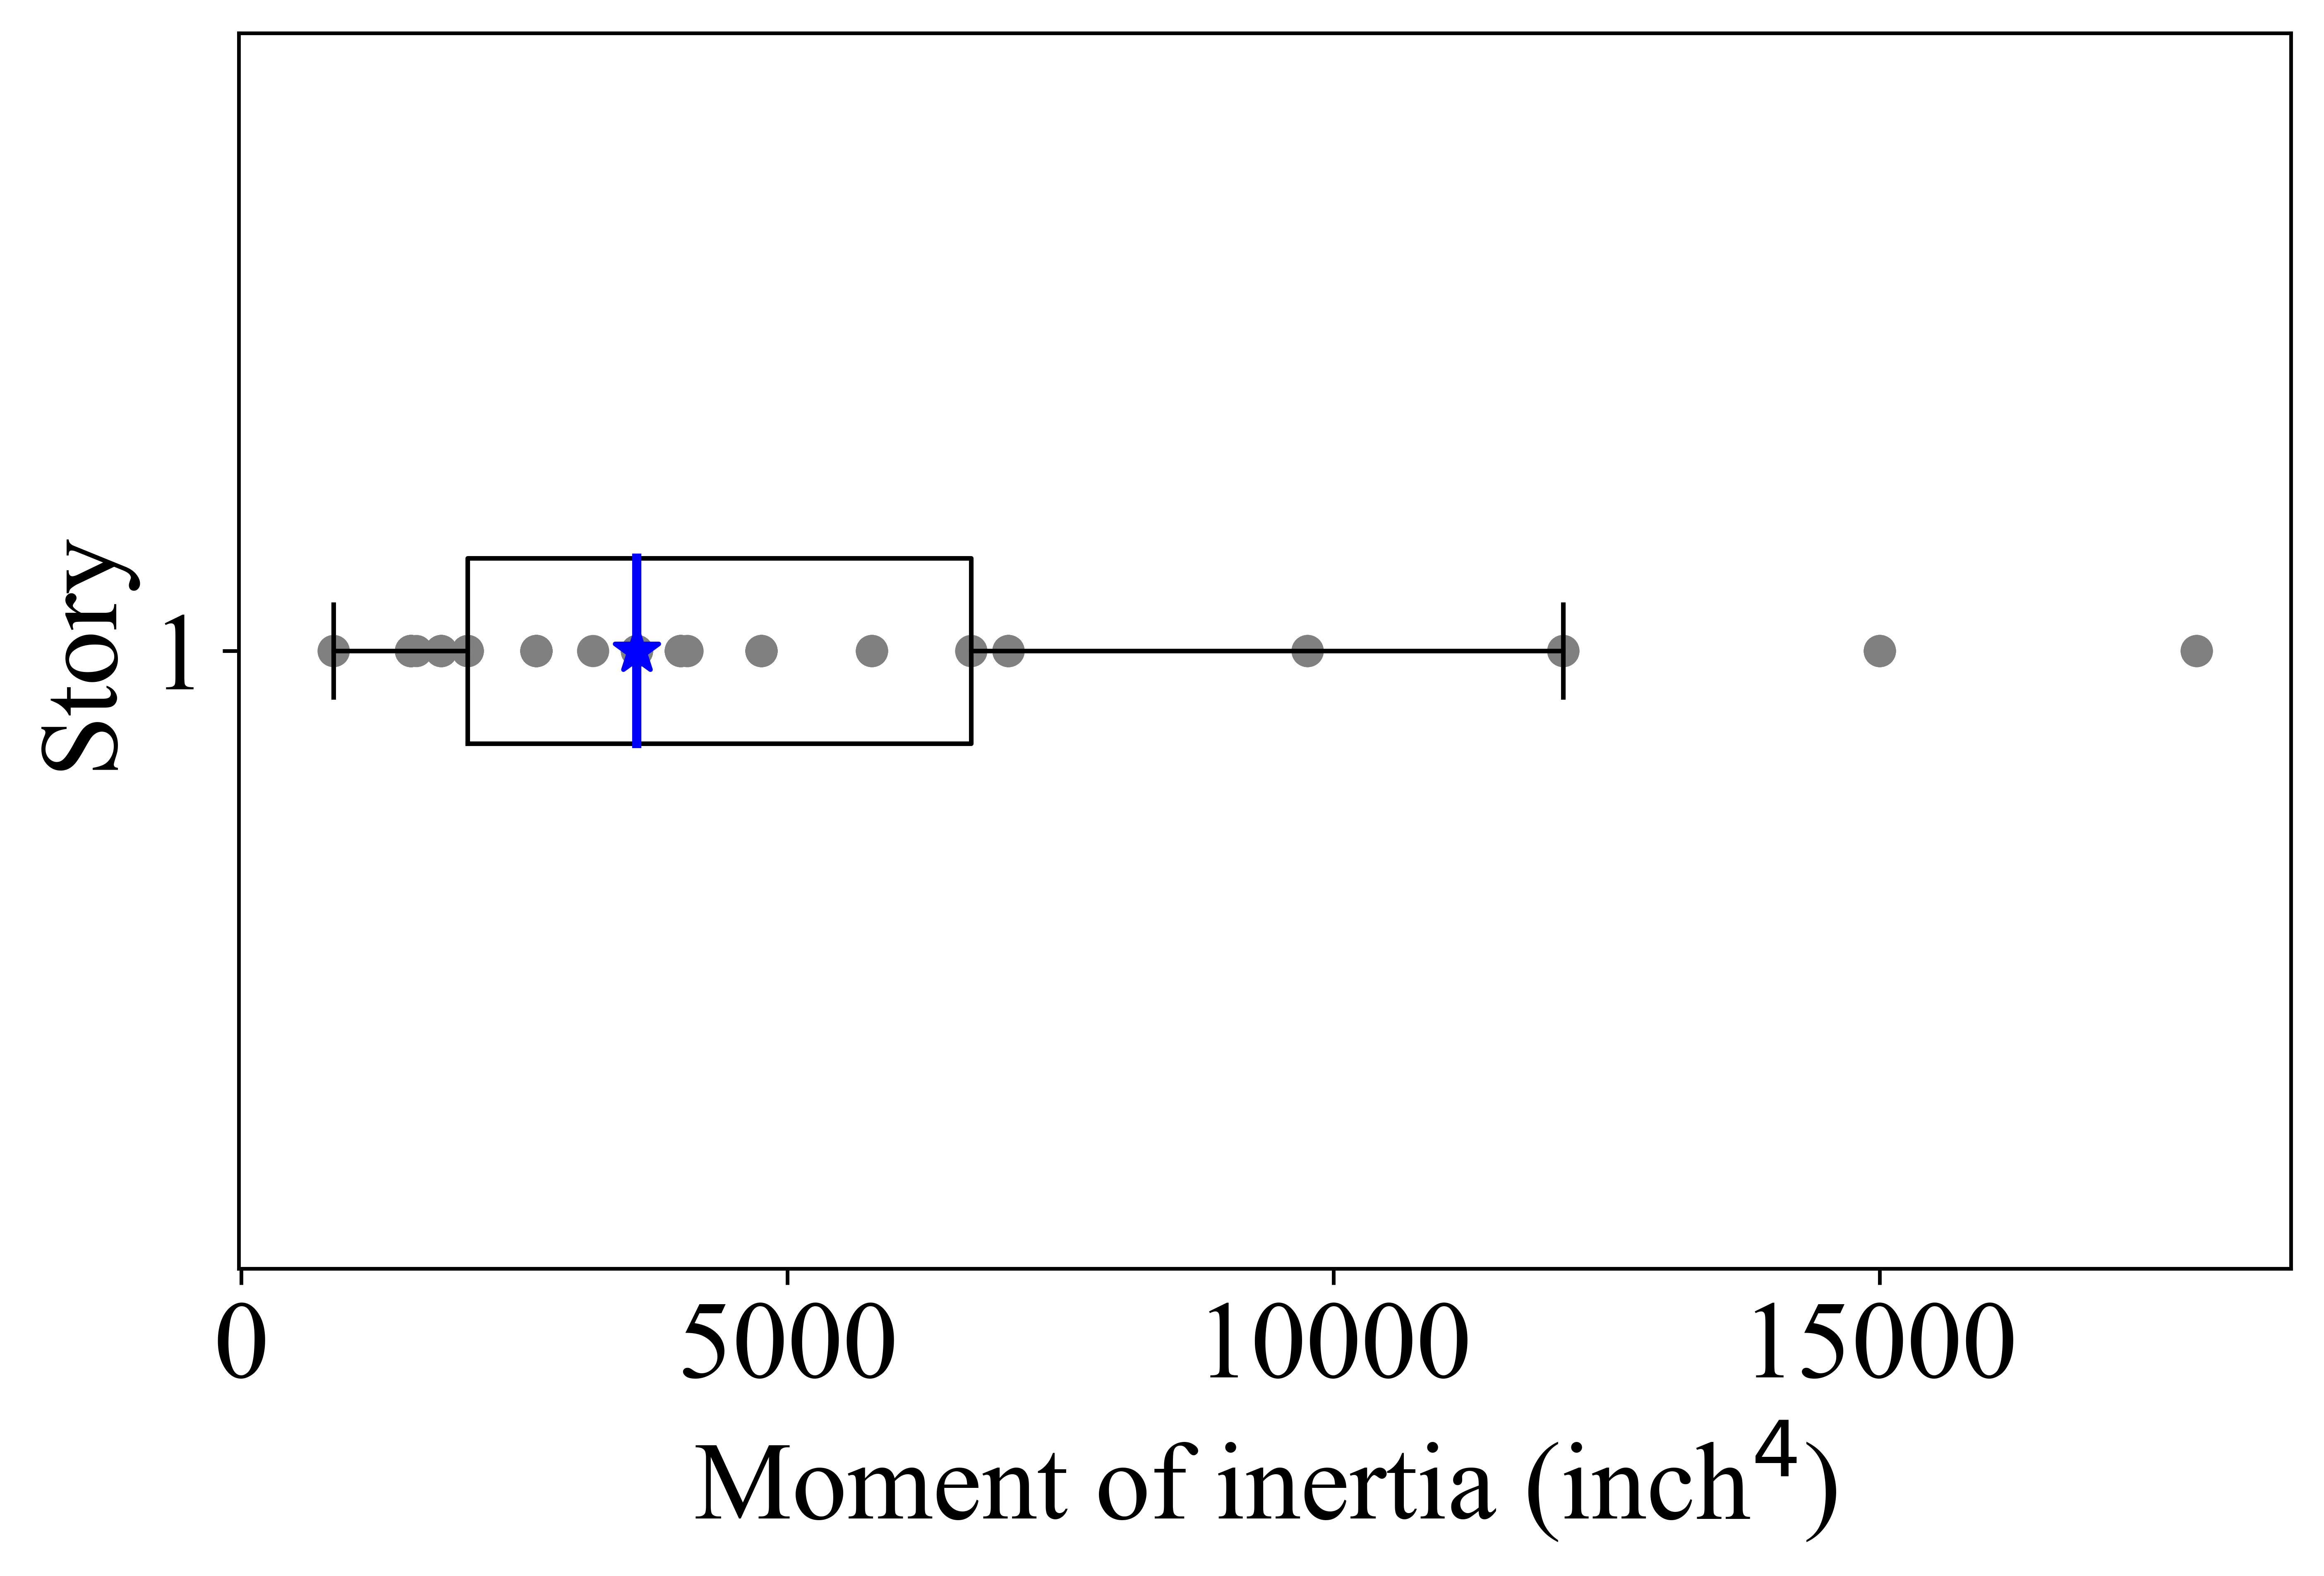

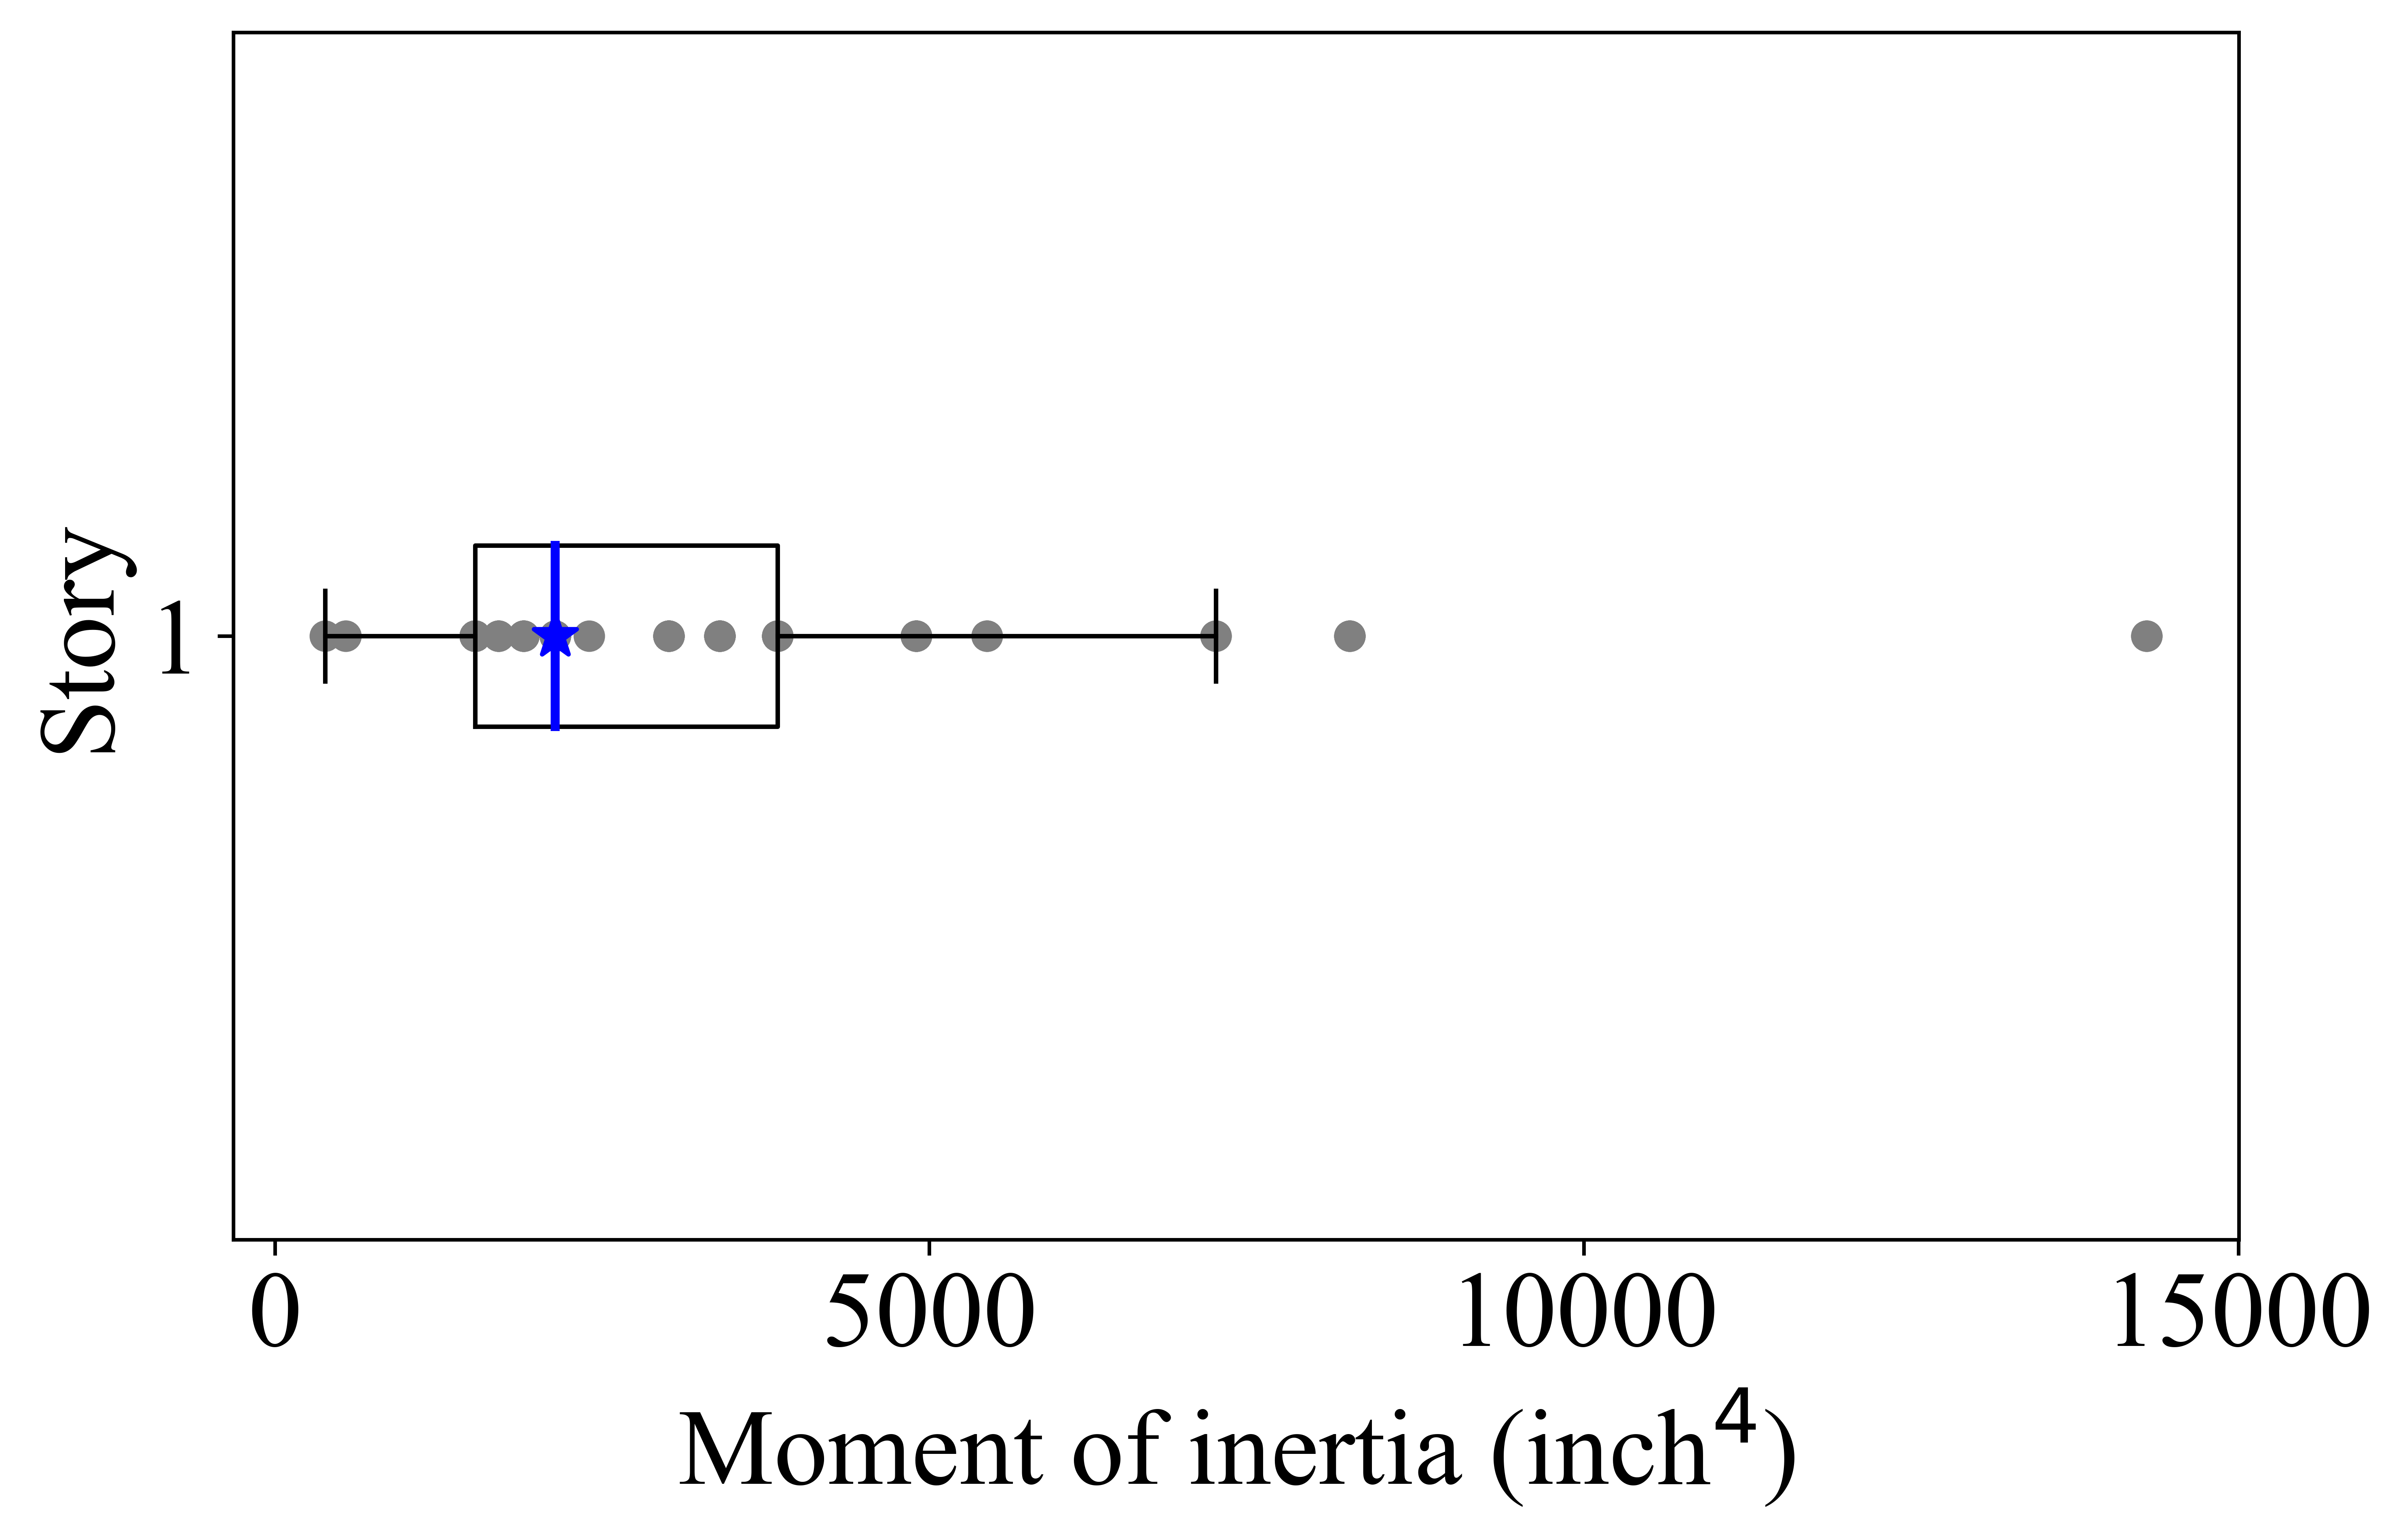

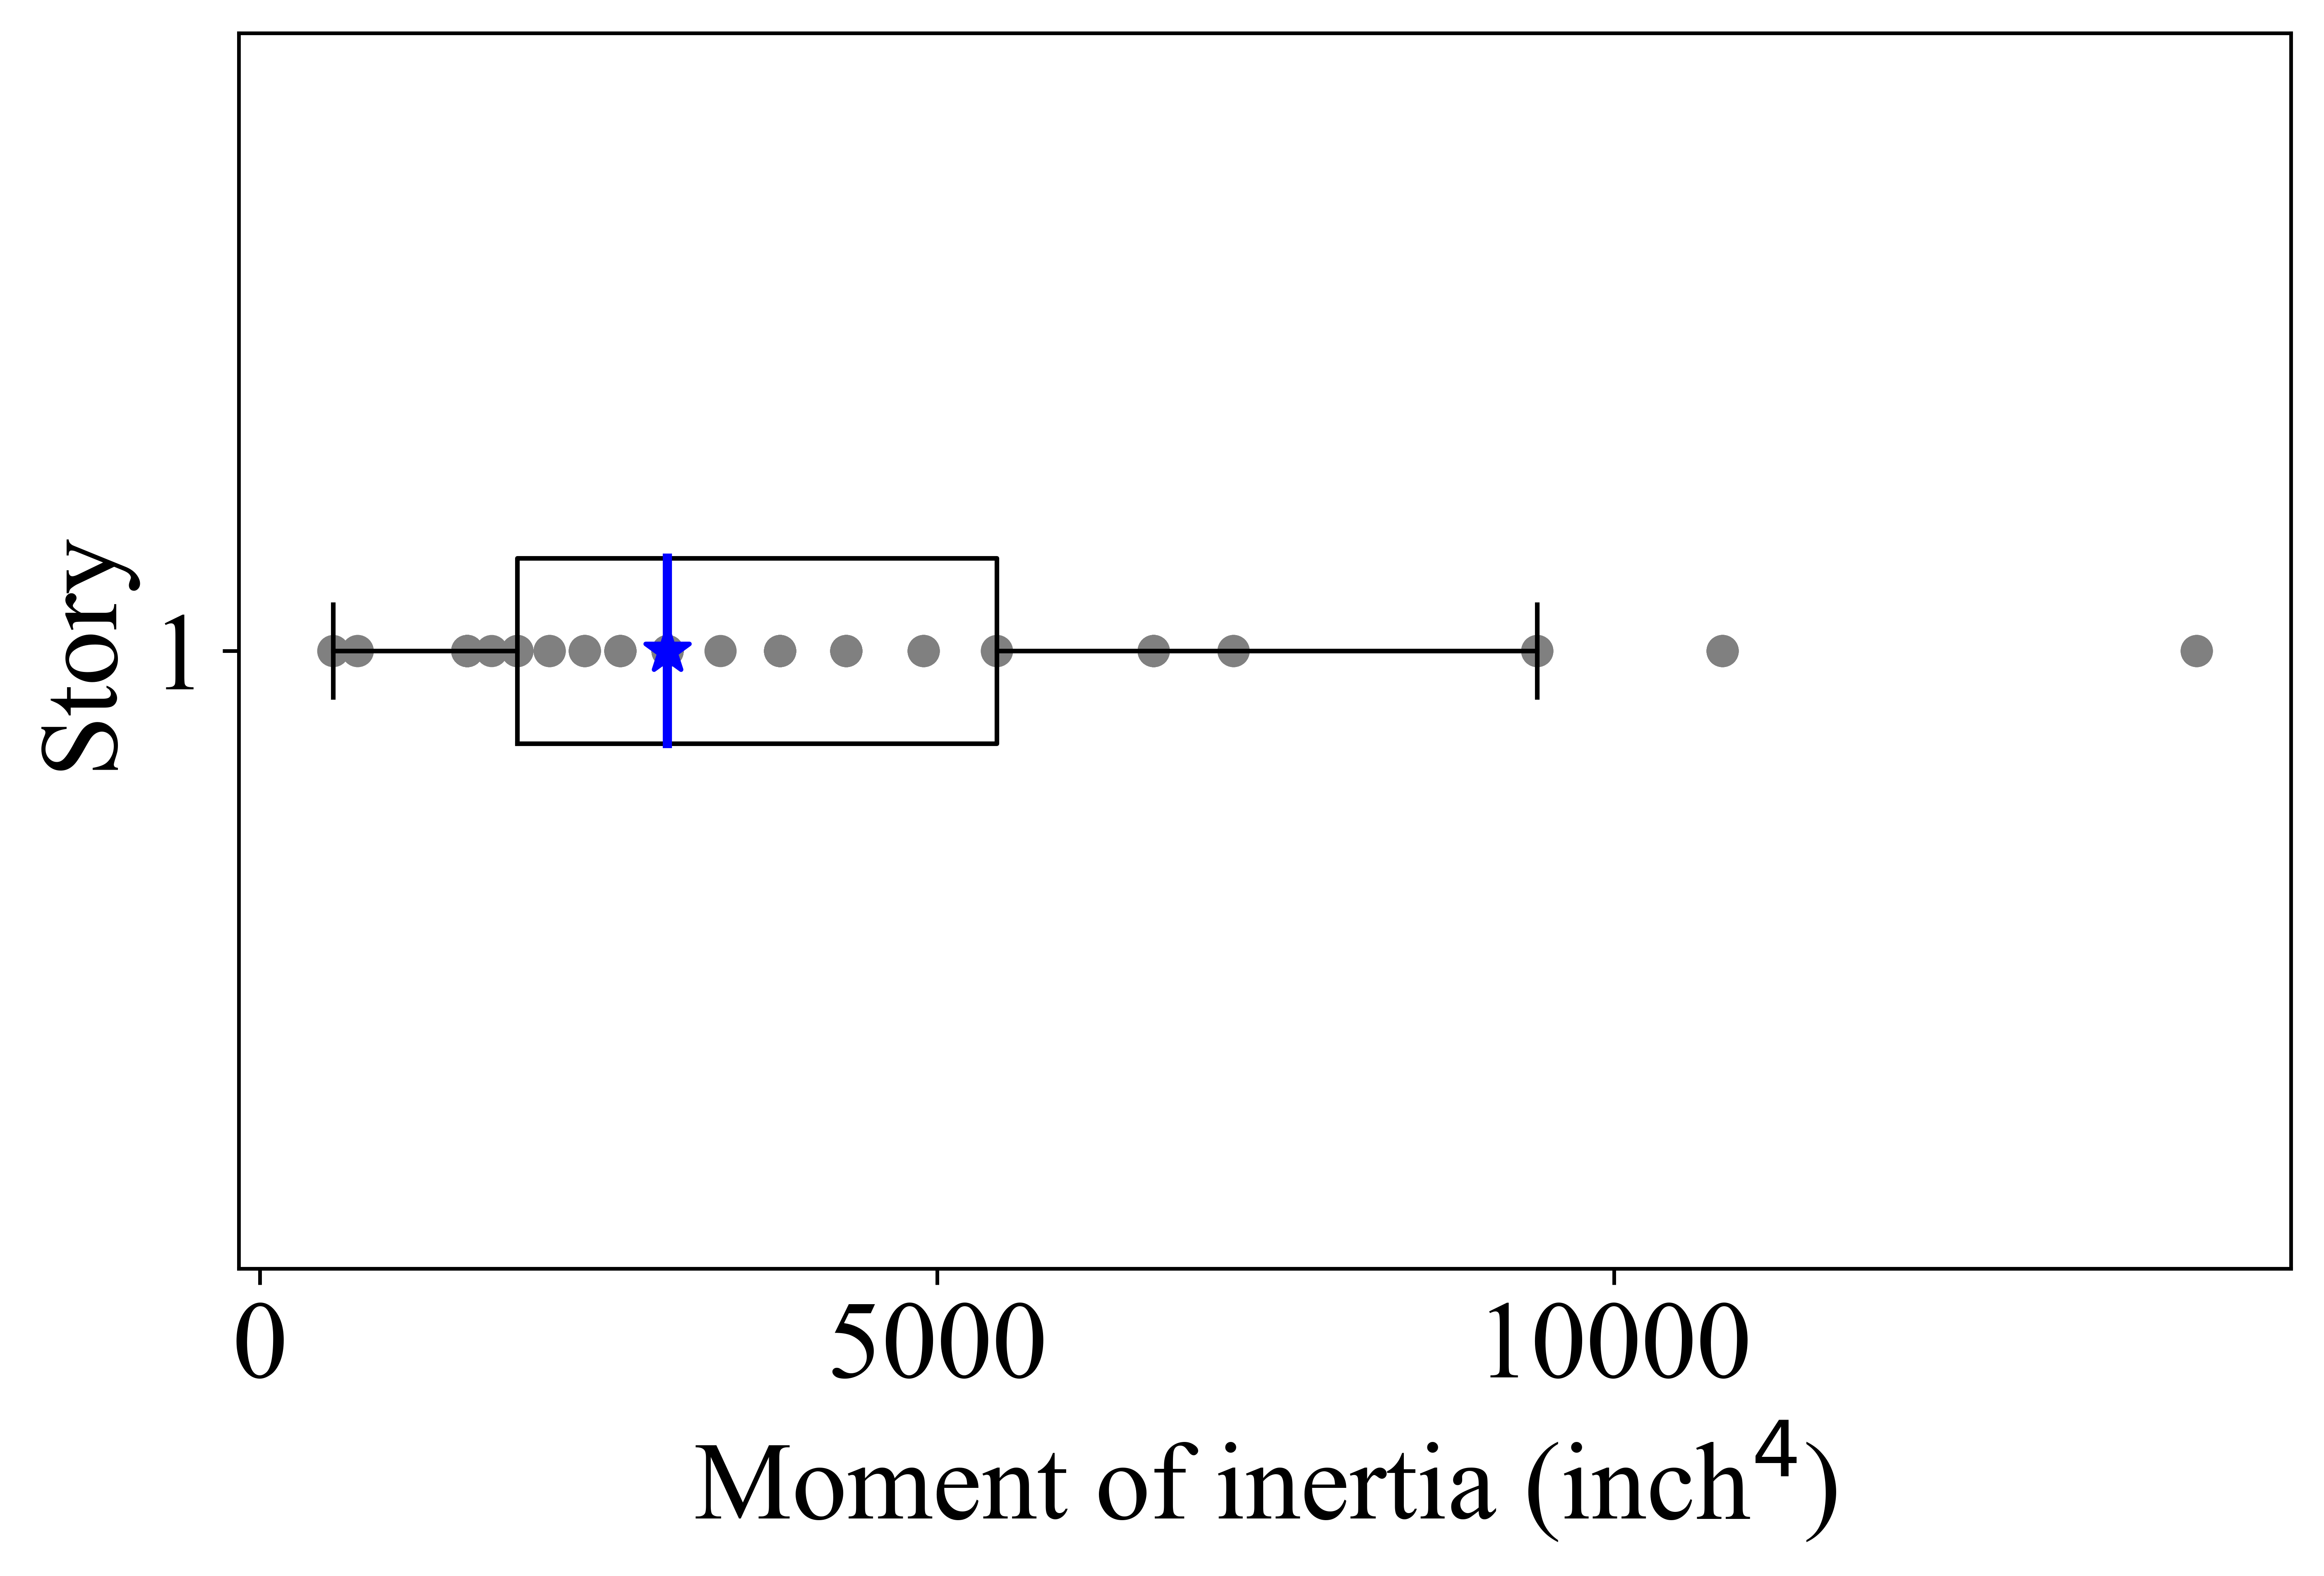

In [5]:
FIGSIZE = (8, 8*0.618)
# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = list(range(1, total_story+1))
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=FIGSIZE, dpi=800)
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False, showfliers=False)
    for median in box['medians']:
        median.set(color='b', linewidth=2,)
    # *********************** Revision for color of box plot ********************
#     colors = ['cyan']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    median = []
    for story in range(0, total_story):
        median.append(np.median(member_property[mn], axis=0))
    FONTSIZE = 24
    plt.scatter(median, story_level, marker='*', s=100, color='blue')
    # plt.title(mn+' Ix vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Moment of inertia (inch$^4$)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.locator_params(axis='x', nbins=6)
    plt.show()

# Plot Zx vs. Story Level

In [7]:
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'Zx')

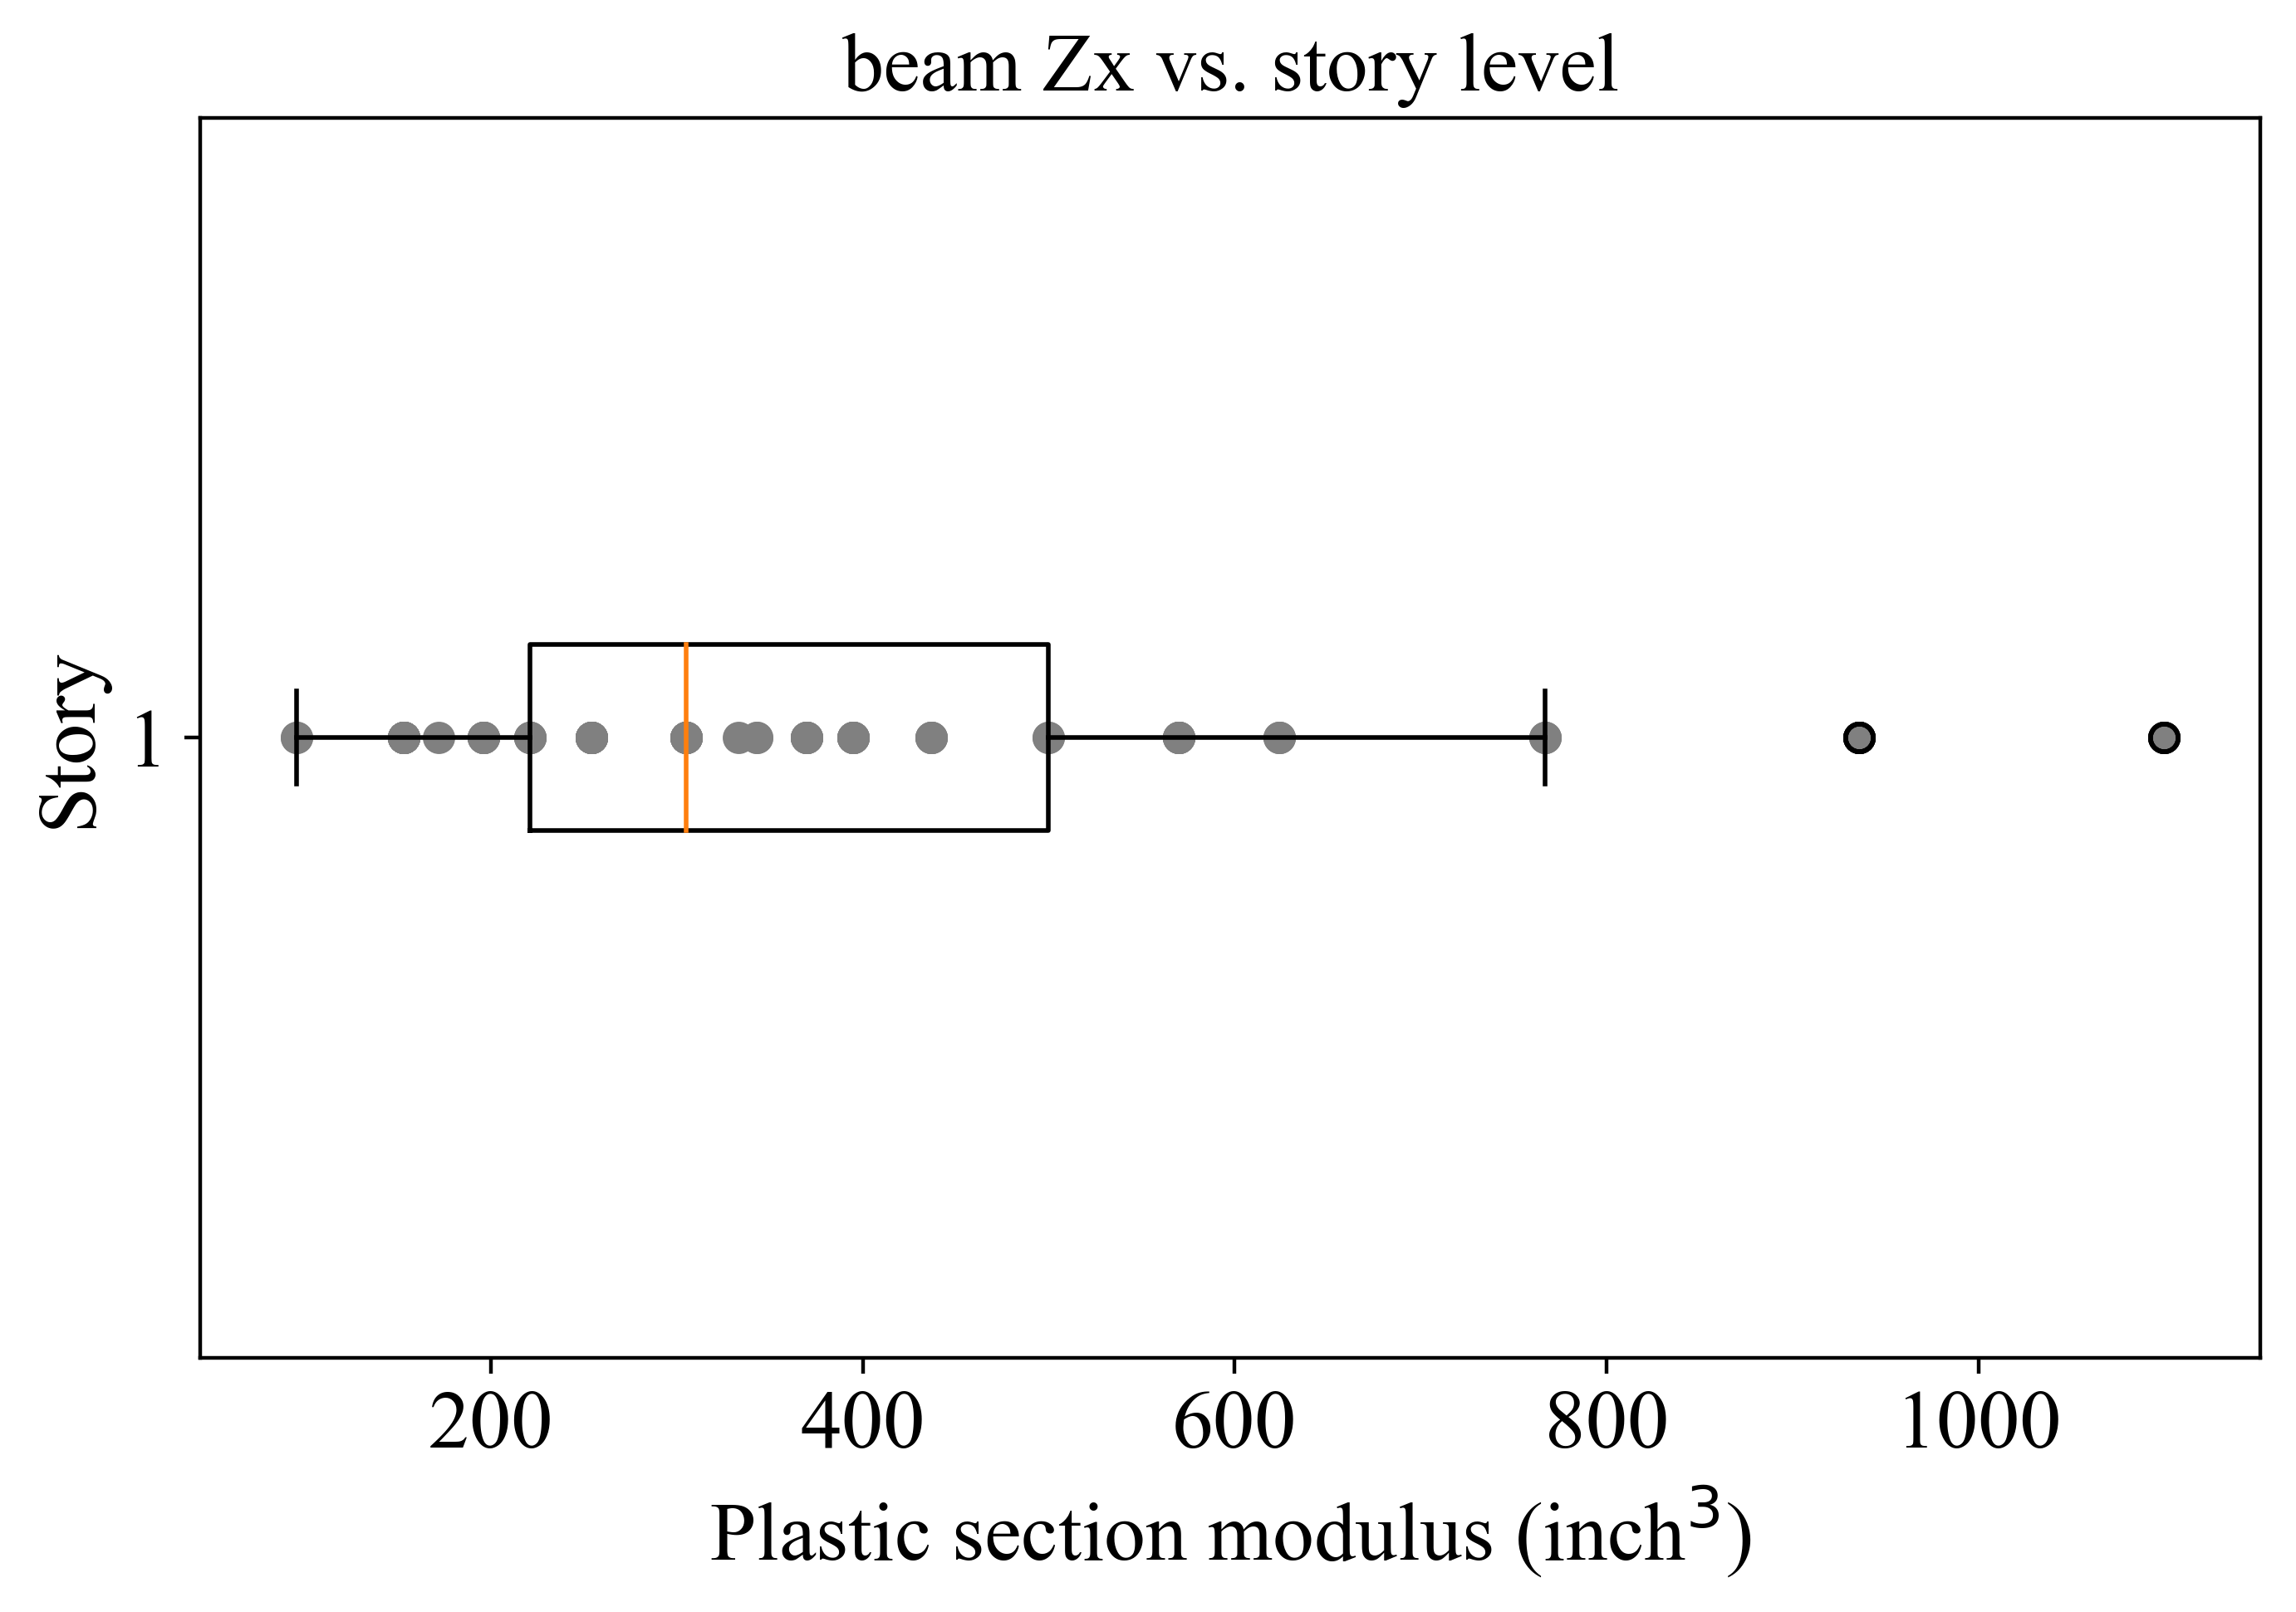

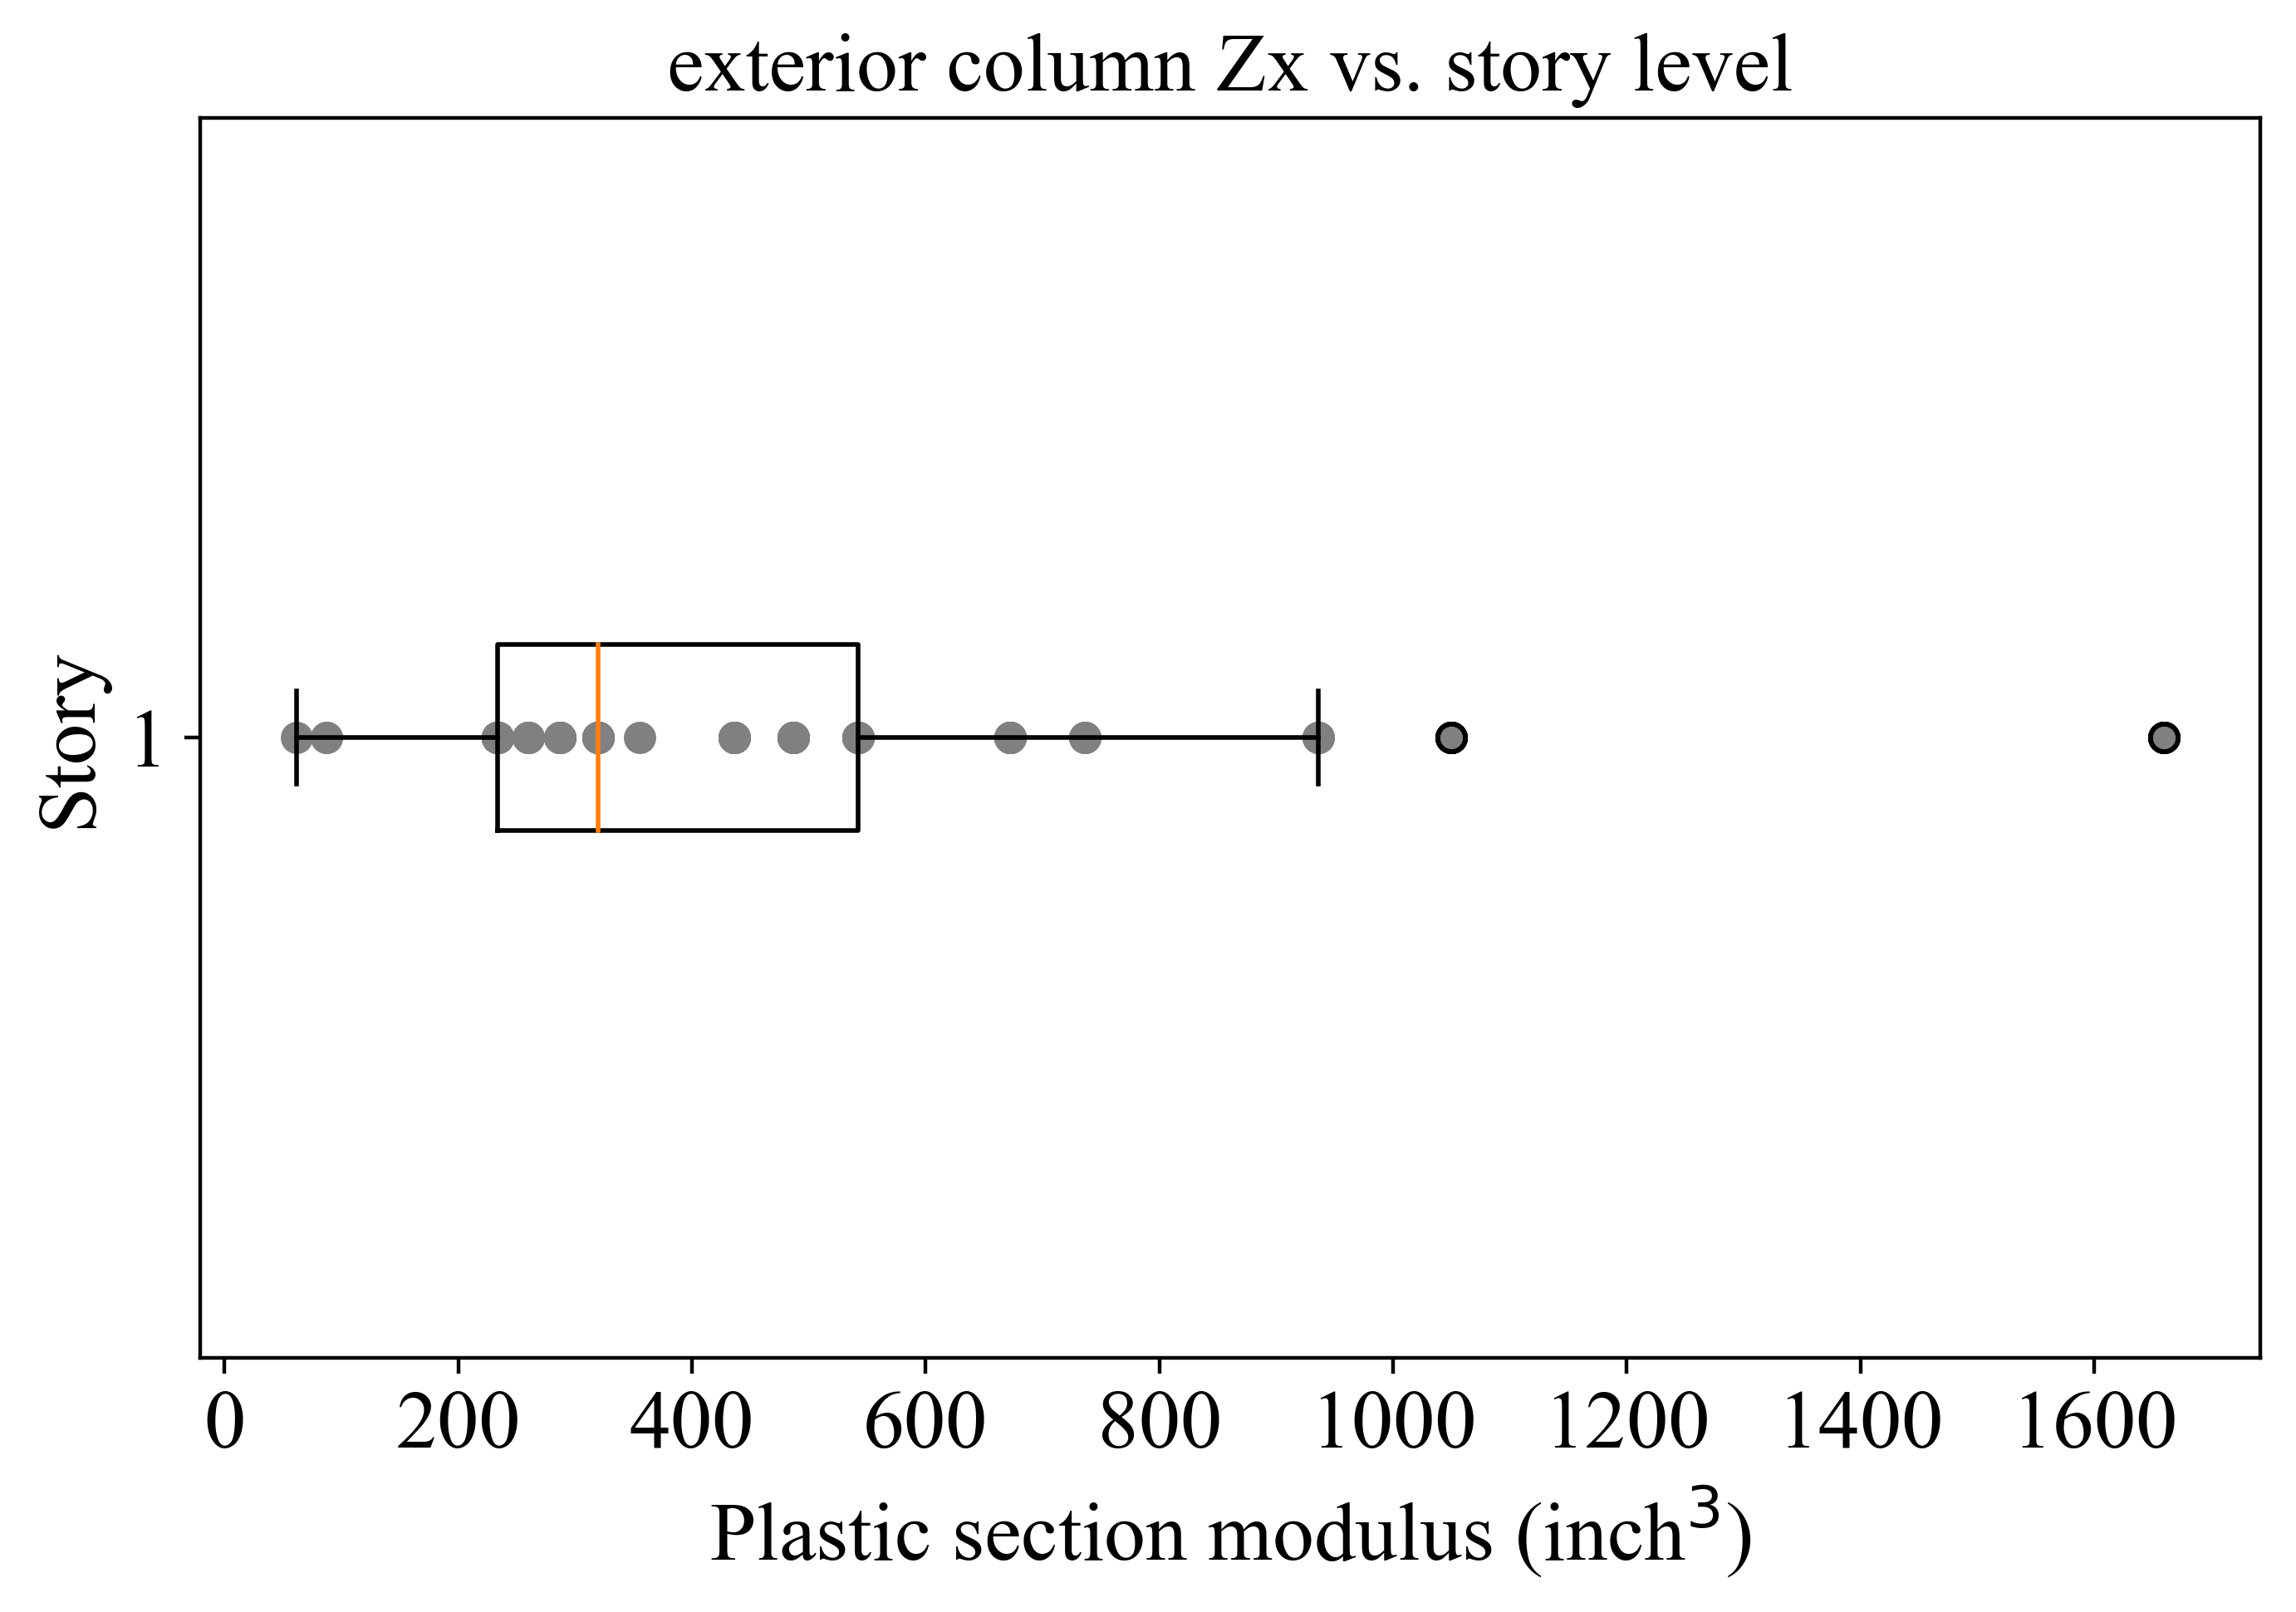

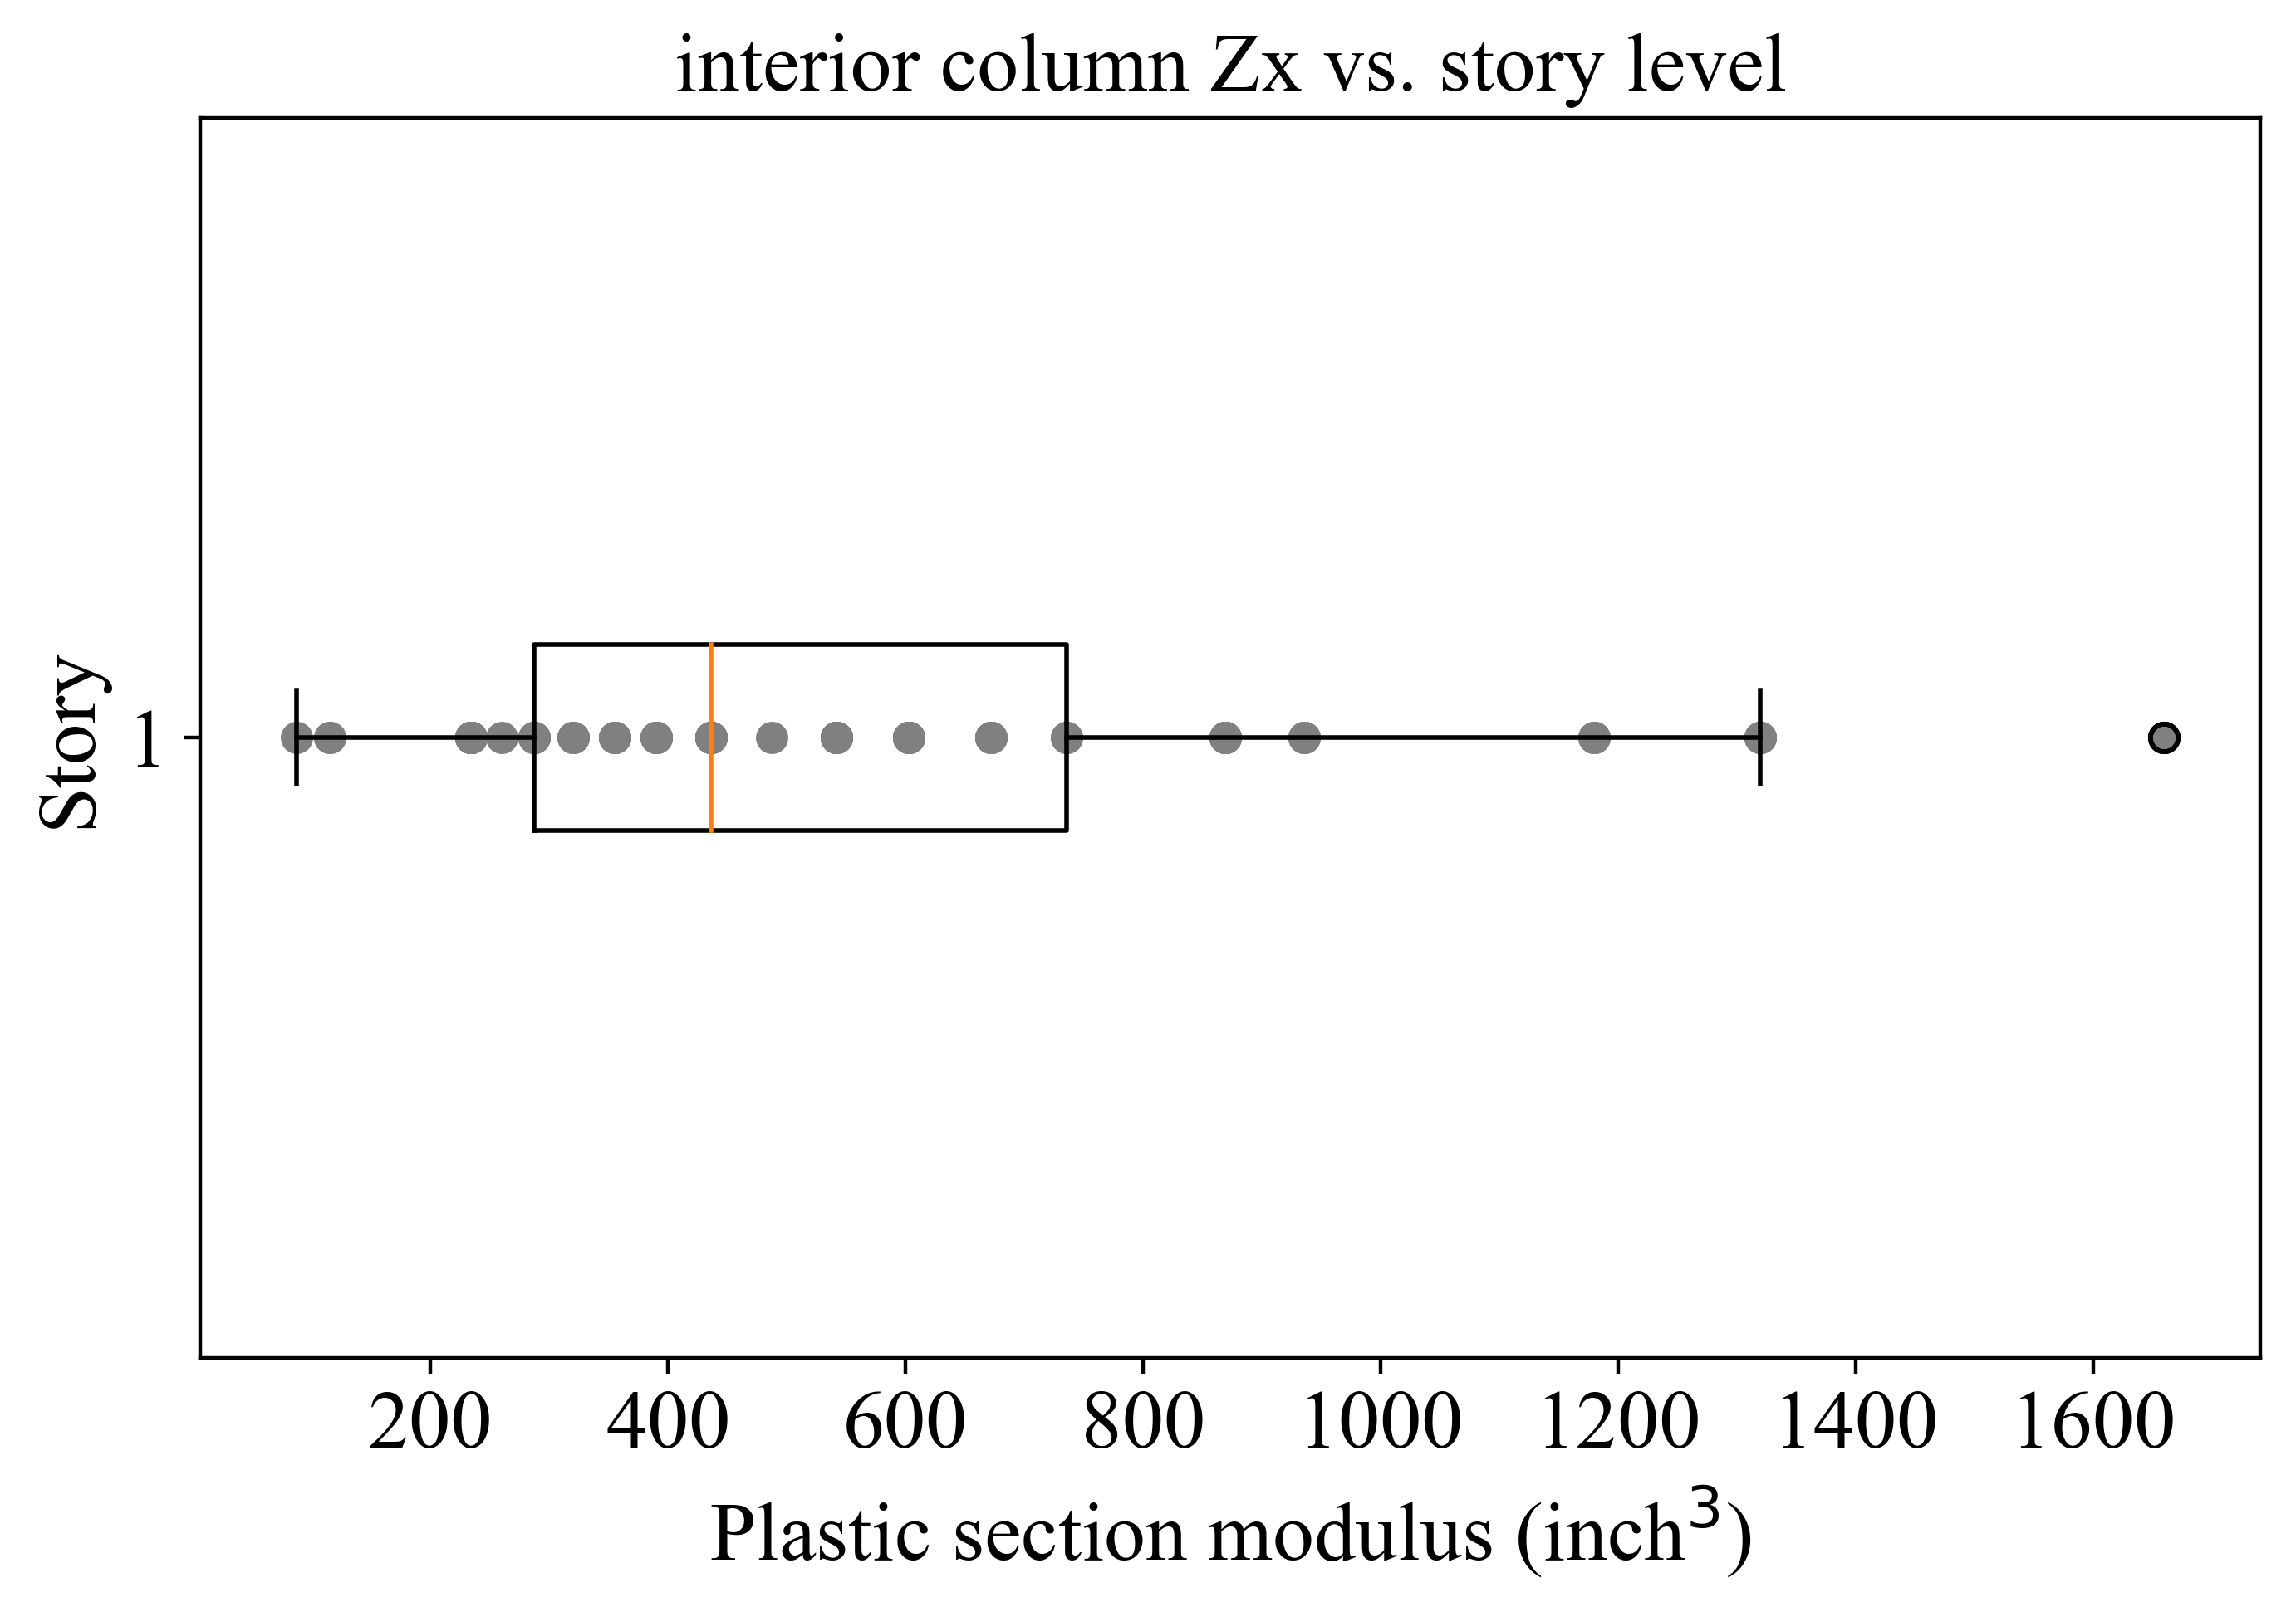

In [9]:
# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = range(1, total_story+1)
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=FIGSIZE, dpi=400)
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False)
    # *********************** Revision for color of box plot ********************
#     colors = ['blue']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    FONTSIZE = 18
    plt.title(mn+' Zx vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Plastic section modulus (inch$^3$)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()

# Plot Weight vs. Story Level

In [9]:
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'weight')

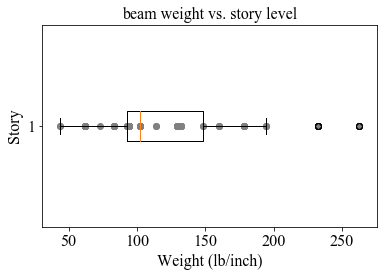

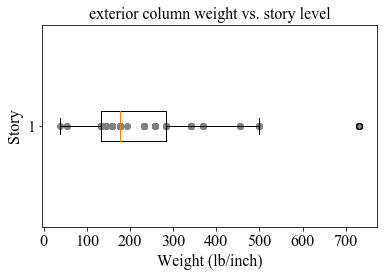

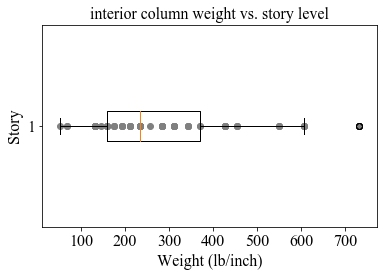

In [10]:
# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = range(1, total_story+1)
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=(6, 6*0.618))
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False)
    # *********************** Revision for color of box plot ********************
#     colors = ['pink']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    FONTSIZE = 16
    plt.title(mn+' weight vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Weight (lb/inch)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()

# Plot Story Drift vs. Story Level

In [6]:
file_name = 'OptimalStoryDrift.csv'
optimal_drift = extract_story_drift(target_IDs, file_name, True)
file_name = 'ConstructionDrift.csv'
construction_drift = extract_story_drift(target_IDs, file_name, True)
story_drift = {'optimal drift': optimal_drift, 'construction drift': construction_drift}

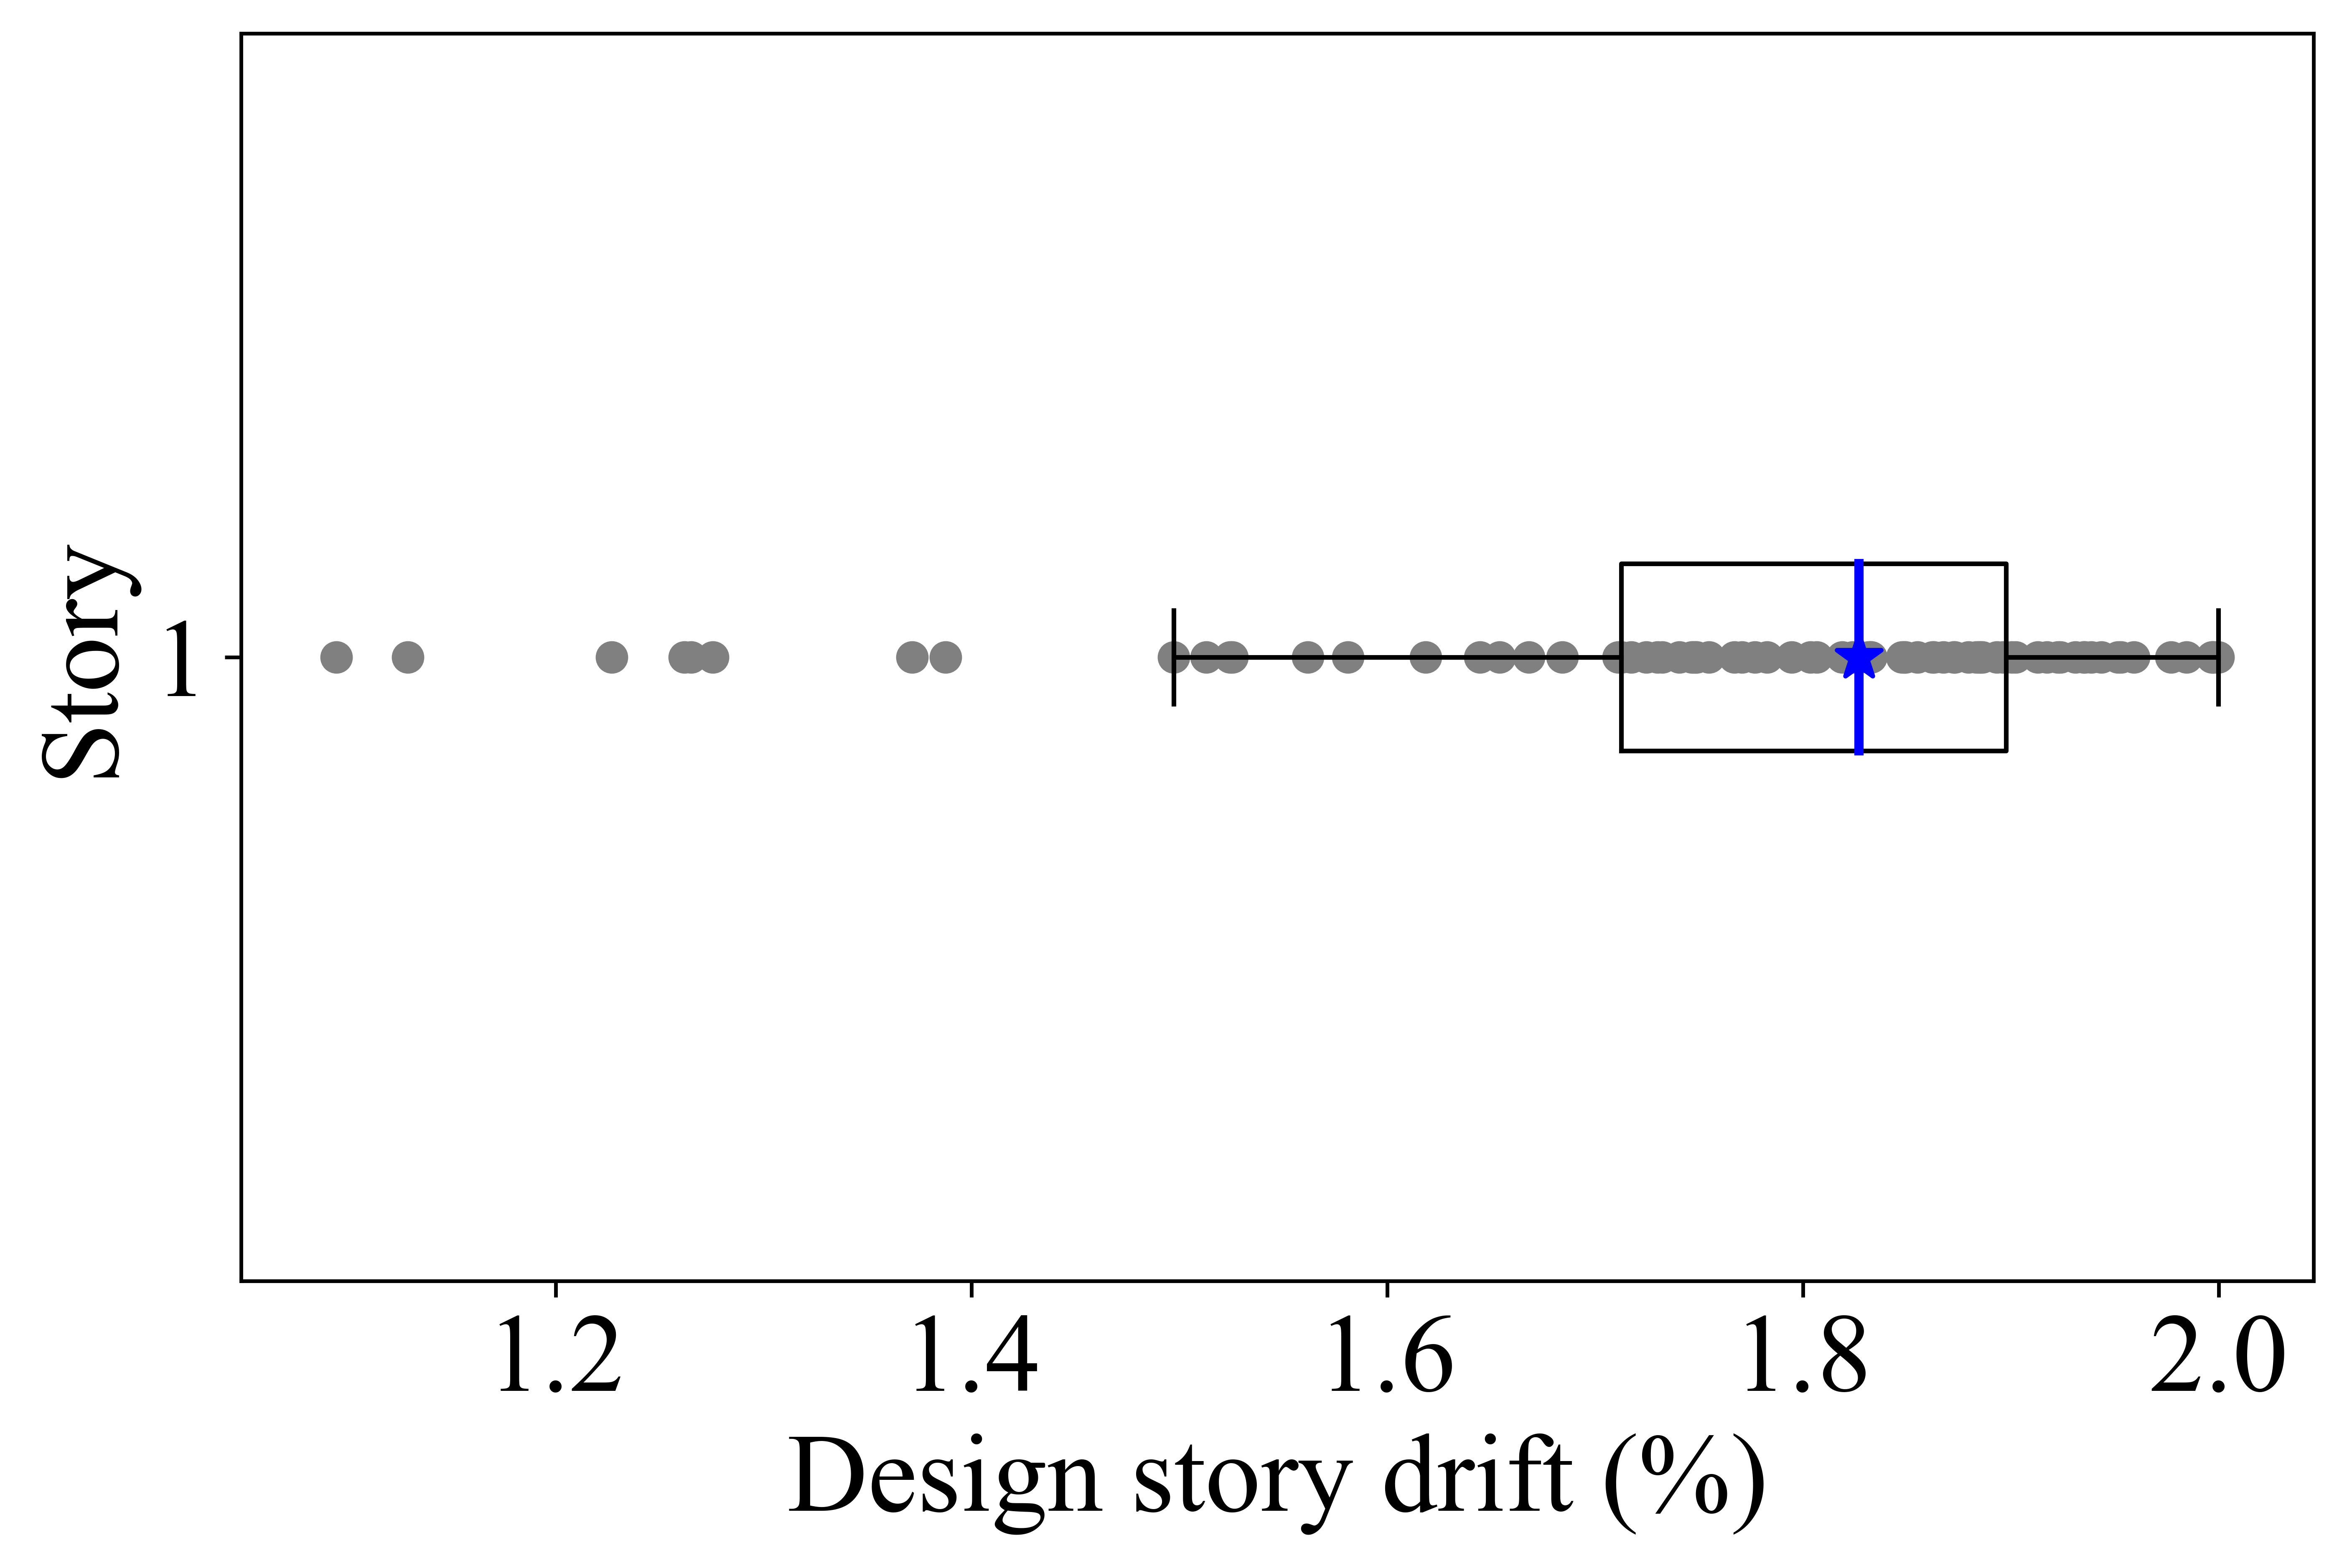

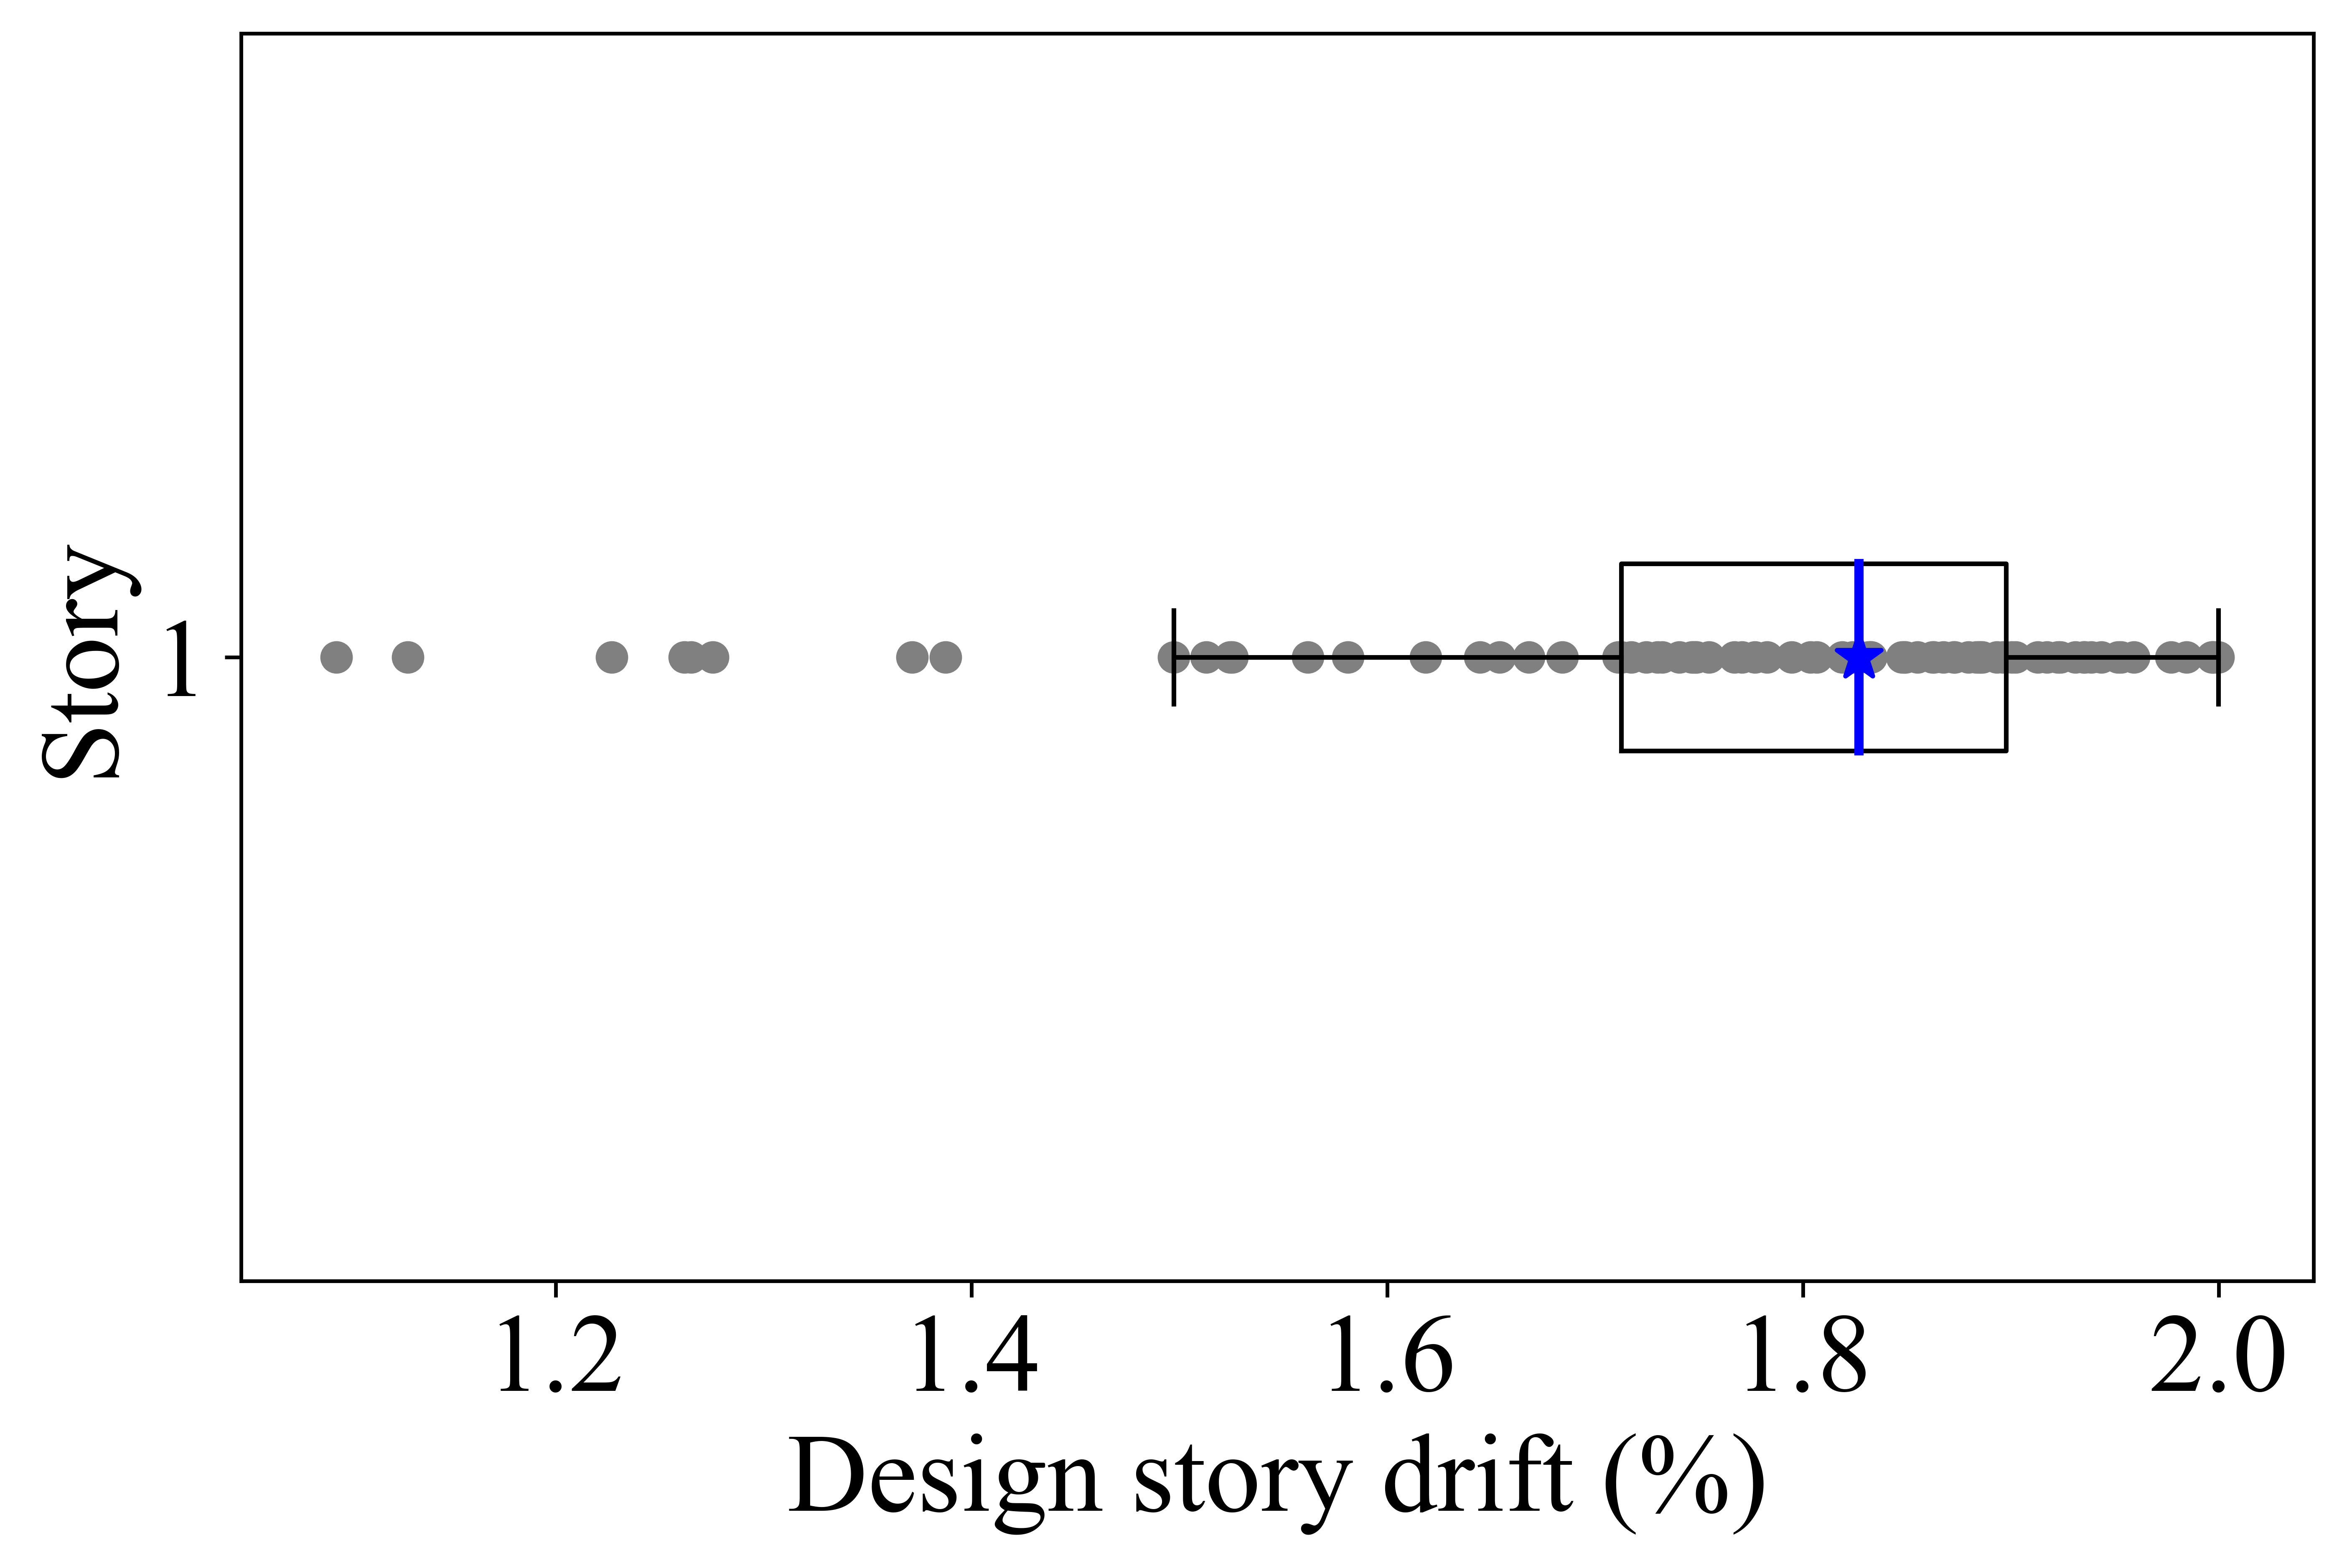

In [7]:
# For optimal/construction story drifts
drift_names = ['optimal drift', 'construction drift']
story_level = range(1, total_story+1)
for mn in drift_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = story_drift[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=(8, 8*0.618), dpi=800)
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, showfliers=False, patch_artist=False, vert=False)
    for median in box['medians']:
        median.set(color='b', linewidth=2,)
    # *********************** Revision for color of box plot ********************
    #     colors = ['pink']
    #     for patch, color in zip(box['boxes'], colors):
    #         patch.set_facecolor(color)   
    for each in range(0, len(target_IDs)):
        if each==0:
            plt.scatter(story_drift[mn][each], story_level, color='grey', label='Indivial building')
        else:
            plt.scatter(story_drift[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    median = []
    for story in range(0, total_story):
        median.append(np.median(vec[story]))
    plt.scatter(median, story_level, marker='*', s=100, color='blue', label='Median')
    FONTSIZE = 24
    # plt.title(mn+' vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Design story drift (%)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks([1])
    # plt.legend(frameon=True, prop={'family': 'Times New Roman', 'size': FONTSIZE})
    plt.show()

In [14]:
drift_all_buildings = story_drift['construction drift']
# Compute the DCR ratios
average_story_drift_per_building = list([])
max_story_drift_per_building = list([])
DCR_ratios = list([])
for building_index in range(0, len(target_IDs)):
    average_story_drift_per_building.append(np.mean(drift_all_buildings[building_index]))
    max_story_drift_per_building.append(np.max(drift_all_buildings[building_index]))
    DCR_ratios.append( np.max(drift_all_buildings[building_index]) / np.mean(drift_all_buildings[building_index]) )

In [15]:
# save to .csv file
dataFrame = pd.DataFrame(data = np.column_stack([average_story_drift_per_building, max_story_drift_per_building, \
                                                DCR_ratios]), columns = ['average', 'max', 'DCR'])
os.chdir("C:\\Users\\Lenovo\\Desktop")
dataFrame.to_csv("OneStoryBuildingDRC.csv", index=False, sep=',')

# For Some Other Conditions (e.g. Building Bay > 1)

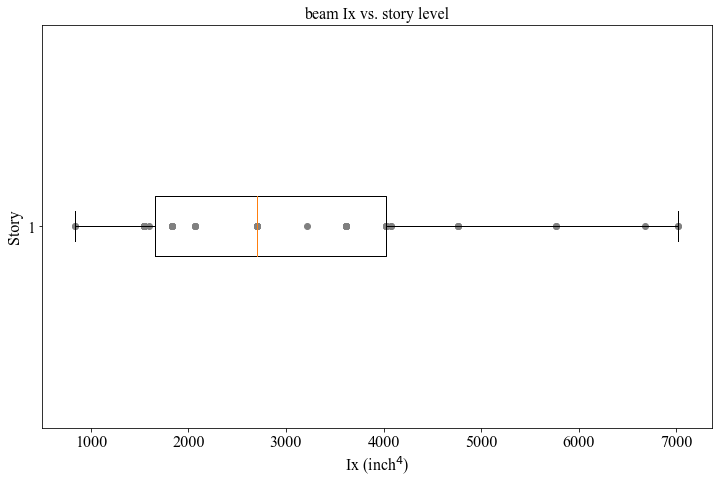

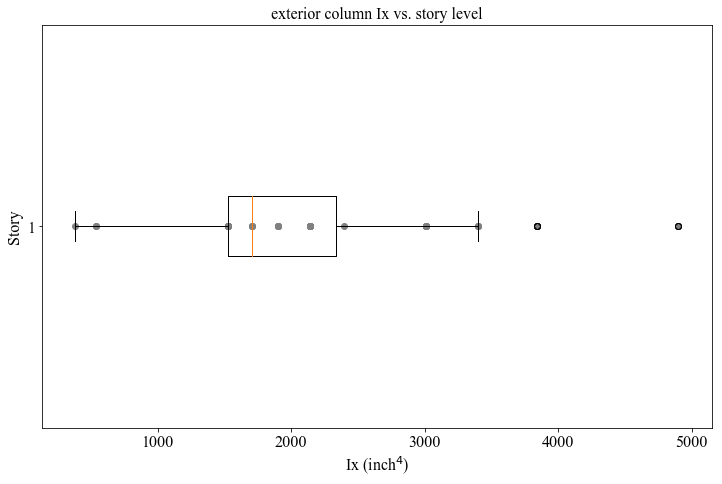

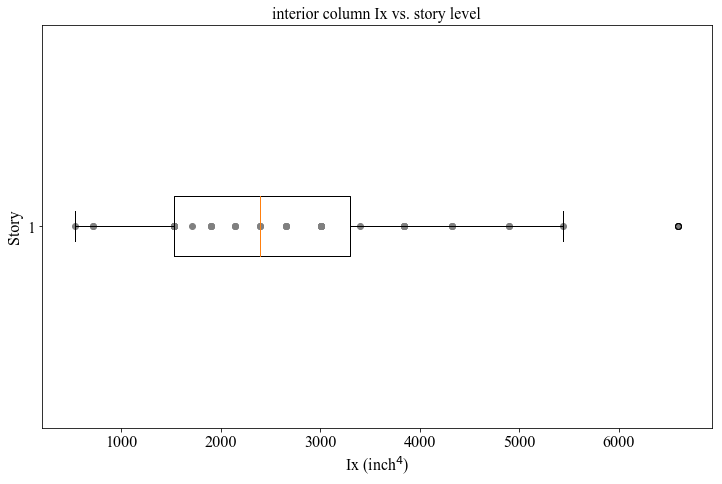

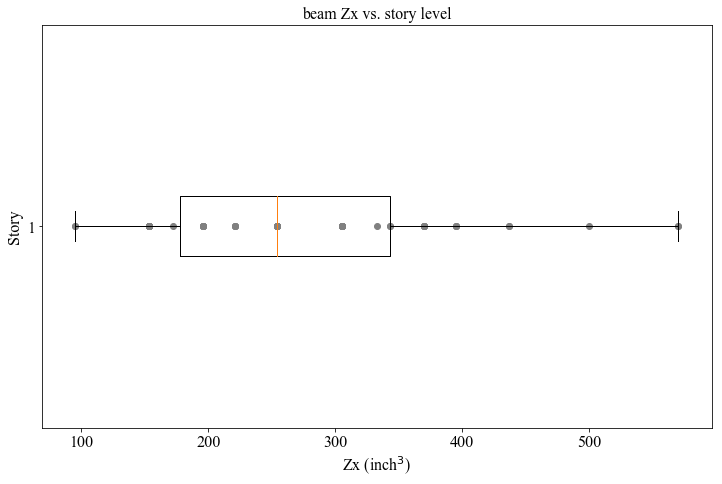

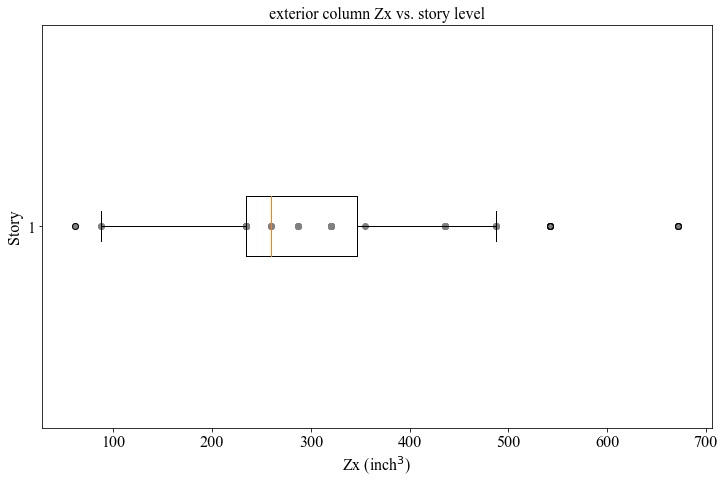

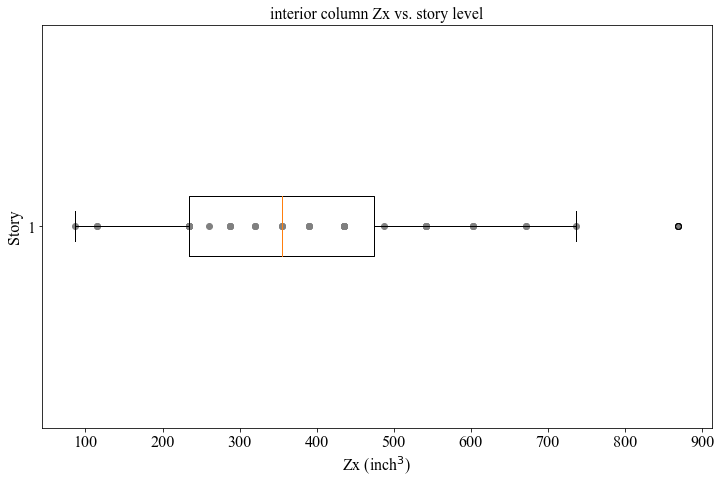

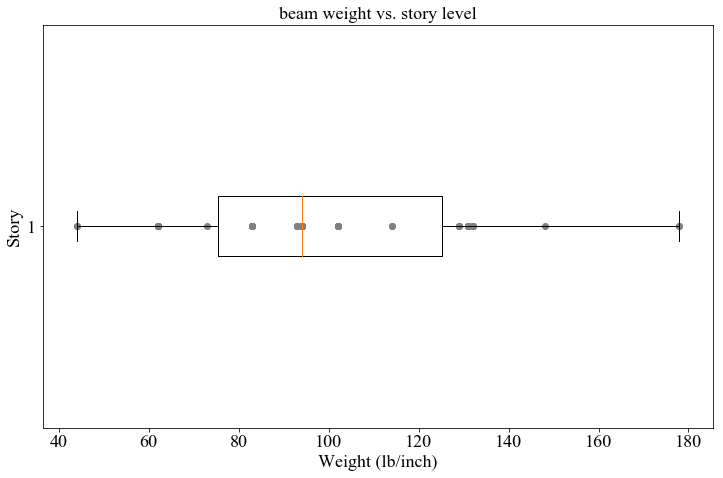

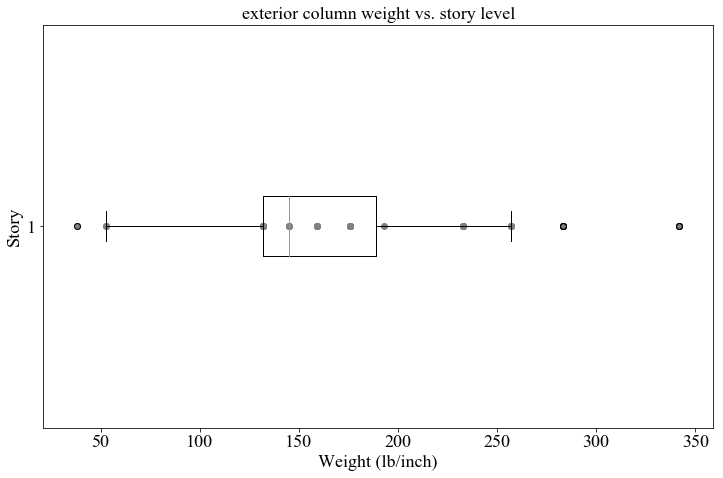

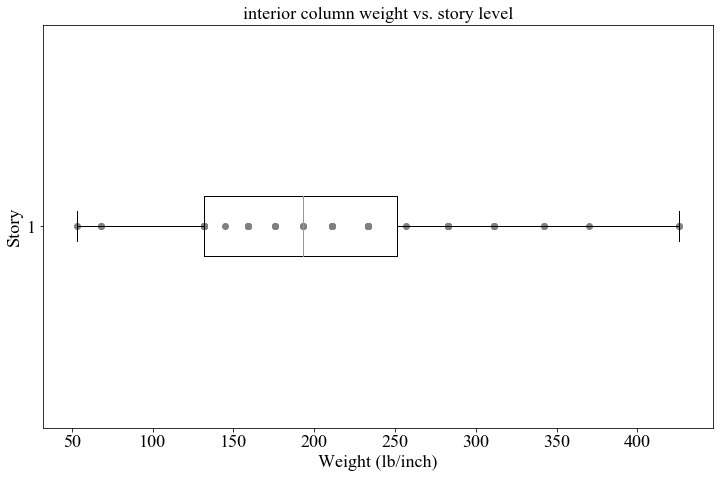

In [15]:
# Find the building IDs that we are interested in.
target_IDs = []
row_number = DESIGN_SPACE.shape[0]
for indx in range(0, row_number):
    if DESIGN_SPACE.loc[indx, 'number of story'] == 1 and DESIGN_SPACE.loc[indx, 'number of bay'] != 1:
        target_IDs.append(DESIGN_SPACE.loc[indx, 'building ID'])

if (is_construction):
    file_name = 'ConstructionSize.csv'
else:
    file_name = 'OptimalMemberSize.csv'
members = extract_member_results(target_IDs, file_name)


# ****************************************** For Ix **********************************************
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'Ix')
# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = range(1, total_story+1)
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=(12, 12*0.618))
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False)
    # *********************** Revision for color of box plot ********************
#     colors = ['cyan']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    FONTSIZE = 16
    plt.title(mn+' Ix vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Ix (inch$^4$)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()

# ******************************************* For Zx *****************************************************
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'Zx')

# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = range(1, total_story+1)
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=(12, 12*0.618))
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False)
    # *********************** Revision for color of box plot ********************
#     colors = ['blue']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    FONTSIZE = 16
    plt.title(mn+' Zx vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Zx (inch$^3$)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()

    
# *************************************** For weight **********************************
member_property = extract_section_property(len(target_IDs), total_story, members, SECTION_DATABASE, 'weight')

# For beam/exterior column/interior column
# Re-organize the results into a two-dimensional array: first dimension is the number of story. 
#                                                       second dimension is the number of buildings.
member_names = ['beam', 'exterior column', 'interior column']
story_level = range(1, total_story+1)
for mn in member_names:
    vec = [[0] * len(target_IDs) for story in range(0, total_story)]
    for story in range(0, total_story):
        for each in range(0, len(target_IDs)):
            vec[story][each] = member_property[mn][each][story]
    # Plot the box plot
    fig = plt.figure(figsize=(12, 12*0.618))
    box_plot_data = []
    for story in range(0, total_story):
        box_plot_data.append(vec[story])
    box = plt.boxplot(box_plot_data, patch_artist=False, vert=False)
    # *********************** Revision for color of box plot ********************
#     colors = ['pink']
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
    for each in range(0, len(target_IDs)):
        plt.scatter(member_property[mn][each], story_level, color='grey')
    # ************************ Revision ends here *******************************
    FONTSIZE = 18
    plt.title(mn+' weight vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('Weight (lb/inch)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()

In [14]:
len(target_IDs)

54

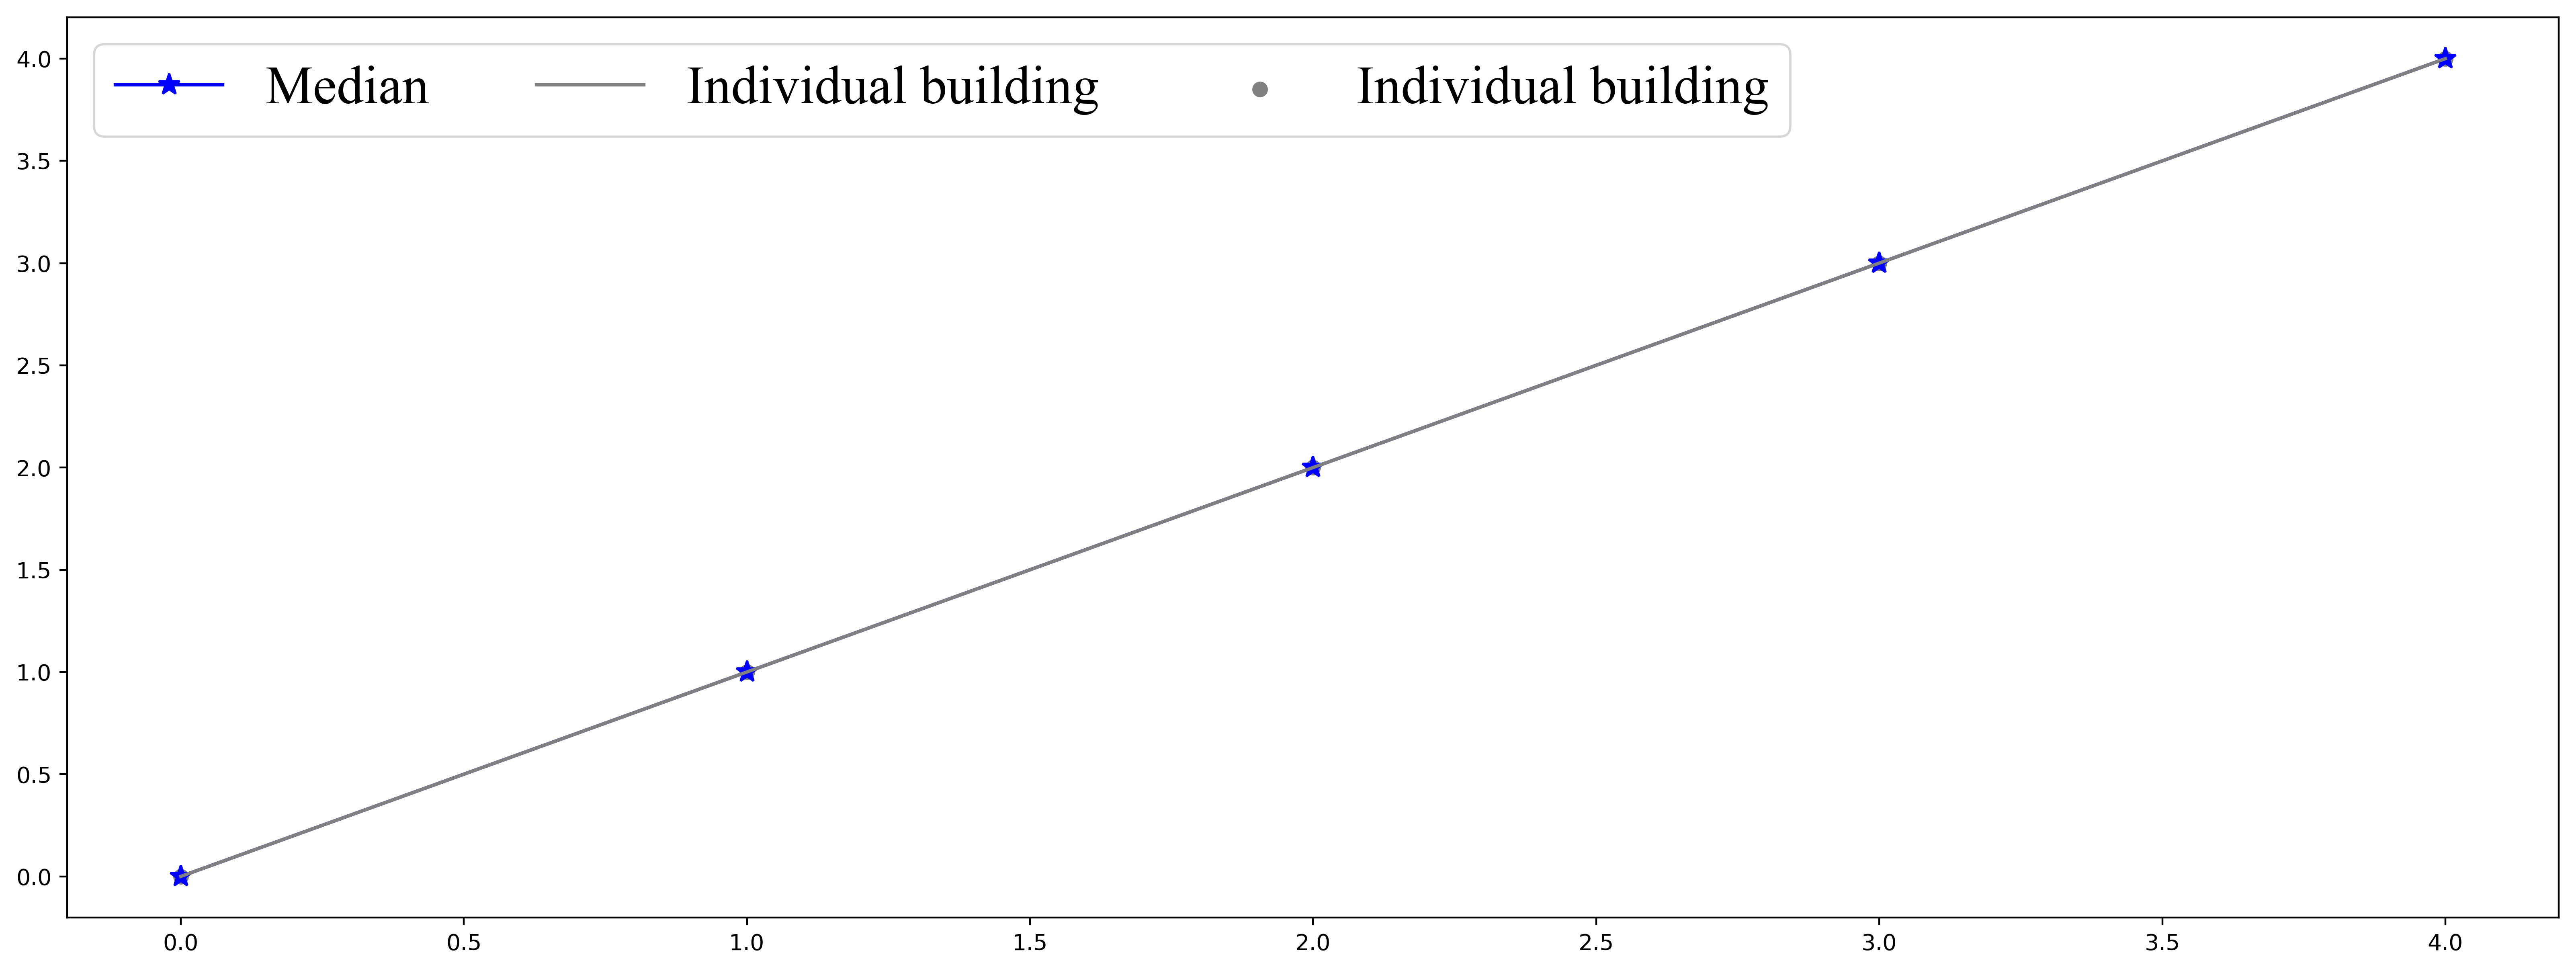

In [26]:
a = [0, 1, 2, 3, 4]
b = [0, 1, 2, 3, 4]
fig = plt.figure(figsize=(20, 12*0.618), dpi=400)
plt.scatter(a, b, color='grey', label='Individual building')
plt.plot(a, b,marker='*', ms=10, color='blue', label='Median')
plt.plot(a, b, color='grey', label='Individual building')
plt.legend(frameon=True, ncol=3, prop={'family': 'Times New Roman', 'size': FONTSIZE})
plt.show()